In [1]:
import torch
import numpy as np
import pandas as pd
import skimage.io
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import kornia as K
import cv2

import albumentations as A
import tensorflow as tf
from sklearn.model_selection import train_test_split
AUTOTUNE = tf.data.experimental.AUTOTUNE

/opt/conda/lib/python3.7/site-packages/skimage/filters/rank/generic.py:49: DeprecationWarning: invalid escape sequence \-
  """


In [2]:
class config:
    train_path = "../input/cell-data-20211207/cell_dataset/train"
    test_path = "../input/cell-data-20211207/cell_dataset/test"


In [3]:
os.makedirs("./cellpose/train/mask/img")
os.makedirs("./cellpose/train/image/img")

In [4]:
train_mask_list = sorted(["../input/cell-data-20211207/cell_dataset/train" + "/" + i for i in os.listdir(config.train_path) if i.split(".")[0][-6:-1] == "_mask"])
train_img_list = sorted(["../input/cell-data-20211207/cell_dataset/train" + "/" + i for i in os.listdir(config.train_path) if i.split(".")[0][-6:-1] != "_mask"])

dest_img = "./cellpose/train/image/img"
dest_mask = "./cellpose/train/mask/img"

for i in train_img_list:
    img = cv2.imread(i,cv2.IMREAD_COLOR)
    filename = dest_img + "/" +i.split("/")[-1]
    cv2.imwrite(filename,img)
    
for i in train_mask_list:
    mask = cv2.imread(i,cv2.IMREAD_COLOR)
    filename = dest_mask + "/" +i.split("/")[-1]
    cv2.imwrite(filename,mask)
    
    
    

In [5]:
# os.makedirs("./cellpose/aug_train/mask/img")
# os.makedirs("./cellpose/aug_train/image/img")
os.makedirs("./cellpose/aug_test/img")

In [6]:
base_test = "../input/cell-data-20211207/cell_dataset/test"
test_list = [base_test + "/"+ i  for i in os.listdir(base_test)]
dest_test = "./cellpose/aug_test/img"

for i in test_list:
    img = cv2.imread(i,cv2.IMREAD_COLOR)
    filename = dest_test + "/" +i.split("/")[-1]
    cv2.imwrite(filename,img)

In [7]:
# !ls ./cellpose/aug_test/img

In [8]:
os.makedirs("./cellpose/aug_train/img")

In [9]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)
import numpy as np
import albumentations as A

def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

# for image in images:
#     for i in range(NUM_AUG_REPEAT):


def strong_aug_2(p=0.5):
    return A.Compose([
#             A.Resize(image_size1, image_size2),
            A.RandomResizedCrop(image_size1, image_size1),
            A.Transpose(p=0.5),
            A.SafeRotate(45,p=0.5),
#             A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            ], p=p)

cellpose_mask =  "./cellpose/train/mask/img"
cellpose_img =  "./cellpose/train/image/img"

cellpose_mask_list = sorted([cellpose_mask + "/" + i for i in os.listdir(cellpose_mask) if i.split(".")[0][-6:-1] == "_mask"])
cellpose_img_list = sorted([cellpose_img + "/" + i for i in os.listdir(cellpose_img) if i.split(".")[0][-6:-1] != "_mask"])

NUM_AUG_REPEAT = 5
image_size1 = 520
image_size2 = 704


for msk,img in tqdm(zip(cellpose_mask_list,cellpose_img_list)):
    for i in range(NUM_AUG_REPEAT):
        image = plt.imread(img)
        mask = plt.imread(msk)
        augmentation = strong_aug_2(p=0.9)
        data = {"image": image, "mask": mask}
        augmented = augmentation(**data)
        image, mask = augmented["image"], augmented["mask"]
        
#         image = image.reshape((520,704,3))
#         mask = mask.reshape((520,704,3))

        
        mask_file = "./cellpose/aug_train/img" + "/" + msk.split("/")[-1].split(".")[0].split("_")[0] + "_" +str(i) + "_masks"+ ".tif"
        img_file = "./cellpose/aug_train/img" + "/" + img.split("/")[-1].split(".")[0] + "_" +str(i) + ".tif"
        
        cv2.imwrite(mask_file,mask)
        cv2.imwrite(img_file,image)
        
        print(f"successfulling saved ============= {mask_file} ============== and ============== {img_file} ===============")

# # whatever_data = "my name"


# # # print(image)
# # plt.figure(figsize=(20,22))
# # plt.subplot(1,2,1)
# # plt.imshow(image)

# # plt.subplot(1,2,2)
# # plt.imshow(mask)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


successfulling saved ============= ./cellpose/aug_train/img/0140b3c8f445_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0140b3c8f445_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0140b3c8f445_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0140b3c8f445_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0140b3c8f445_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0140b3c8f445_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0140b3c8f445_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0140b3c8f445_3.tif ===============


1it [00:00,  2.78it/s]

successfulling saved ============= ./cellpose/aug_train/img/0140b3c8f445_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0140b3c8f445_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/01ae5a43a2ab_0_masks.tif ============== and ============== ./cellpose/aug_train/img/01ae5a43a2ab_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/01ae5a43a2ab_1_masks.tif ============== and ============== ./cellpose/aug_train/img/01ae5a43a2ab_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/01ae5a43a2ab_2_masks.tif ============== and ============== ./cellpose/aug_train/img/01ae5a43a2ab_2.tif ===============


2it [00:00,  3.07it/s]

successfulling saved ============= ./cellpose/aug_train/img/01ae5a43a2ab_3_masks.tif ============== and ============== ./cellpose/aug_train/img/01ae5a43a2ab_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/01ae5a43a2ab_4_masks.tif ============== and ============== ./cellpose/aug_train/img/01ae5a43a2ab_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/026b3c2c4b32_0_masks.tif ============== and ============== ./cellpose/aug_train/img/026b3c2c4b32_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/026b3c2c4b32_1_masks.tif ============== and ============== ./cellpose/aug_train/img/026b3c2c4b32_1.tif ===============


3it [00:00,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/026b3c2c4b32_2_masks.tif ============== and ============== ./cellpose/aug_train/img/026b3c2c4b32_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/026b3c2c4b32_3_masks.tif ============== and ============== ./cellpose/aug_train/img/026b3c2c4b32_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/026b3c2c4b32_4_masks.tif ============== and ============== ./cellpose/aug_train/img/026b3c2c4b32_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/029e5b3b89c7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/029e5b3b89c7_0.tif ===============


4it [00:01,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/029e5b3b89c7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/029e5b3b89c7_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/029e5b3b89c7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/029e5b3b89c7_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/029e5b3b89c7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/029e5b3b89c7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/029e5b3b89c7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/029e5b3b89c7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0323e81d23d9_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0323e81d23d9_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0323e81d23d9_1_masks.tif ============== and =

5it [00:01,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/0323e81d23d9_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0323e81d23d9_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/03b27b381a5f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/03b27b381a5f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/03b27b381a5f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/03b27b381a5f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/03b27b381a5f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/03b27b381a5f_2.tif ===============


6it [00:01,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/03b27b381a5f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/03b27b381a5f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/03b27b381a5f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/03b27b381a5f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/042c17cd9143_0_masks.tif ============== and ============== ./cellpose/aug_train/img/042c17cd9143_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/042c17cd9143_1_masks.tif ============== and ============== ./cellpose/aug_train/img/042c17cd9143_1.tif ===============


7it [00:02,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/042c17cd9143_2_masks.tif ============== and ============== ./cellpose/aug_train/img/042c17cd9143_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/042c17cd9143_3_masks.tif ============== and ============== ./cellpose/aug_train/img/042c17cd9143_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/042c17cd9143_4_masks.tif ============== and ============== ./cellpose/aug_train/img/042c17cd9143_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/04928f0866b0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/04928f0866b0_0.tif ===============


8it [00:02,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/04928f0866b0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/04928f0866b0_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/04928f0866b0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/04928f0866b0_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/04928f0866b0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/04928f0866b0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/04928f0866b0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/04928f0866b0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/049f02e0f764_0_masks.tif ============== and ============== ./cellpose/aug_train/img/049f02e0f764_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/049f02e0f764_1_masks.tif ============== and =

9it [00:02,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/049f02e0f764_4_masks.tif ============== and ============== ./cellpose/aug_train/img/049f02e0f764_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/04cd81dfb245_0_masks.tif ============== and ============== ./cellpose/aug_train/img/04cd81dfb245_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/04cd81dfb245_1_masks.tif ============== and ============== ./cellpose/aug_train/img/04cd81dfb245_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/04cd81dfb245_2_masks.tif ============== and ============== ./cellpose/aug_train/img/04cd81dfb245_2.tif ===============


10it [00:03,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/04cd81dfb245_3_masks.tif ============== and ============== ./cellpose/aug_train/img/04cd81dfb245_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/04cd81dfb245_4_masks.tif ============== and ============== ./cellpose/aug_train/img/04cd81dfb245_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/053d61766edb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/053d61766edb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/053d61766edb_1_masks.tif ============== and ============== ./cellpose/aug_train/img/053d61766edb_1.tif ===============


11it [00:03,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/053d61766edb_2_masks.tif ============== and ============== ./cellpose/aug_train/img/053d61766edb_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/053d61766edb_3_masks.tif ============== and ============== ./cellpose/aug_train/img/053d61766edb_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/053d61766edb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/053d61766edb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/05c61f0f46b7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/05c61f0f46b7_0.tif ===============


12it [00:03,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/05c61f0f46b7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/05c61f0f46b7_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/05c61f0f46b7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/05c61f0f46b7_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/05c61f0f46b7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/05c61f0f46b7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/05c61f0f46b7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/05c61f0f46b7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/061b49d7dbbb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/061b49d7dbbb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/061b49d7dbbb_1_masks.tif ============== and =

13it [00:04,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/061b49d7dbbb_3_masks.tif ============== and ============== ./cellpose/aug_train/img/061b49d7dbbb_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/061b49d7dbbb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/061b49d7dbbb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/06c5740c8b18_0_masks.tif ============== and ============== ./cellpose/aug_train/img/06c5740c8b18_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/06c5740c8b18_1_masks.tif ============== and ============== ./cellpose/aug_train/img/06c5740c8b18_1.tif ===============


14it [00:04,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/06c5740c8b18_2_masks.tif ============== and ============== ./cellpose/aug_train/img/06c5740c8b18_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/06c5740c8b18_3_masks.tif ============== and ============== ./cellpose/aug_train/img/06c5740c8b18_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/06c5740c8b18_4_masks.tif ============== and ============== ./cellpose/aug_train/img/06c5740c8b18_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0728b8f39241_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0728b8f39241_0.tif ===============


15it [00:04,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/0728b8f39241_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0728b8f39241_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0728b8f39241_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0728b8f39241_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0728b8f39241_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0728b8f39241_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0728b8f39241_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0728b8f39241_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/07e9ba109e34_0_masks.tif ============== and ============== ./cellpose/aug_train/img/07e9ba109e34_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/07e9ba109e34_1_masks.tif ============== and =

16it [00:05,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/07e9ba109e34_4_masks.tif ============== and ============== ./cellpose/aug_train/img/07e9ba109e34_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/085eb8fec206_0_masks.tif ============== and ============== ./cellpose/aug_train/img/085eb8fec206_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/085eb8fec206_1_masks.tif ============== and ============== ./cellpose/aug_train/img/085eb8fec206_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/085eb8fec206_2_masks.tif ============== and ============== ./cellpose/aug_train/img/085eb8fec206_2.tif ===============


17it [00:05,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/085eb8fec206_3_masks.tif ============== and ============== ./cellpose/aug_train/img/085eb8fec206_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/085eb8fec206_4_masks.tif ============== and ============== ./cellpose/aug_train/img/085eb8fec206_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/08f52aa2add3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/08f52aa2add3_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/08f52aa2add3_1_masks.tif ============== and ============== ./cellpose/aug_train/img/08f52aa2add3_1.tif ===============


18it [00:05,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/08f52aa2add3_2_masks.tif ============== and ============== ./cellpose/aug_train/img/08f52aa2add3_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/08f52aa2add3_3_masks.tif ============== and ============== ./cellpose/aug_train/img/08f52aa2add3_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/08f52aa2add3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/08f52aa2add3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/097d60b2cf71_0_masks.tif ============== and ============== ./cellpose/aug_train/img/097d60b2cf71_0.tif ===============


19it [00:05,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/097d60b2cf71_1_masks.tif ============== and ============== ./cellpose/aug_train/img/097d60b2cf71_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/097d60b2cf71_2_masks.tif ============== and ============== ./cellpose/aug_train/img/097d60b2cf71_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/097d60b2cf71_3_masks.tif ============== and ============== ./cellpose/aug_train/img/097d60b2cf71_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/097d60b2cf71_4_masks.tif ============== and ============== ./cellpose/aug_train/img/097d60b2cf71_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0a6ecc5fe78a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0a6ecc5fe78a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0a6ecc5fe78a_1_masks.tif ============== and =

20it [00:06,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/0a6ecc5fe78a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0a6ecc5fe78a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0ba181d412da_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0ba181d412da_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0ba181d412da_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0ba181d412da_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0ba181d412da_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0ba181d412da_2.tif ===============


21it [00:06,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/0ba181d412da_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0ba181d412da_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0ba181d412da_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0ba181d412da_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0c90b86742b2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0c90b86742b2_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0c90b86742b2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0c90b86742b2_1.tif ===============


22it [00:06,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/0c90b86742b2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0c90b86742b2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0c90b86742b2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0c90b86742b2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0c90b86742b2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0c90b86742b2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0cfdeeb0dded_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0cfdeeb0dded_0.tif ===============


23it [00:07,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/0cfdeeb0dded_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0cfdeeb0dded_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0cfdeeb0dded_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0cfdeeb0dded_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0cfdeeb0dded_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0cfdeeb0dded_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0cfdeeb0dded_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0cfdeeb0dded_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0df9d6419078_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0df9d6419078_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0df9d6419078_1_masks.tif ============== and =

24it [00:07,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/0df9d6419078_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0df9d6419078_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0df9d6419078_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0df9d6419078_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0e1e2b68fa58_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0e1e2b68fa58_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0e1e2b68fa58_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0e1e2b68fa58_1.tif ===============


25it [00:07,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/0e1e2b68fa58_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0e1e2b68fa58_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0e1e2b68fa58_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0e1e2b68fa58_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0e1e2b68fa58_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0e1e2b68fa58_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0ea6df67cc77_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0ea6df67cc77_0.tif ===============


26it [00:08,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/0ea6df67cc77_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0ea6df67cc77_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0ea6df67cc77_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0ea6df67cc77_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0ea6df67cc77_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0ea6df67cc77_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0ea6df67cc77_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0ea6df67cc77_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0eb1d03df587_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0eb1d03df587_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0eb1d03df587_1_masks.tif ============== and =

27it [00:08,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/0eb1d03df587_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0eb1d03df587_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0f2a46026693_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0f2a46026693_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0f2a46026693_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0f2a46026693_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0f2a46026693_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0f2a46026693_2.tif ===============


28it [00:08,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/0f2a46026693_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0f2a46026693_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0f2a46026693_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0f2a46026693_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0f7d009bc5d3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/0f7d009bc5d3_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0f7d009bc5d3_1_masks.tif ============== and ============== ./cellpose/aug_train/img/0f7d009bc5d3_1.tif ===============


29it [00:08,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/0f7d009bc5d3_2_masks.tif ============== and ============== ./cellpose/aug_train/img/0f7d009bc5d3_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0f7d009bc5d3_3_masks.tif ============== and ============== ./cellpose/aug_train/img/0f7d009bc5d3_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/0f7d009bc5d3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/0f7d009bc5d3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/100681b6cc7a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/100681b6cc7a_0.tif ===============


30it [00:09,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/100681b6cc7a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/100681b6cc7a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/100681b6cc7a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/100681b6cc7a_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/100681b6cc7a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/100681b6cc7a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/100681b6cc7a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/100681b6cc7a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/115fad550598_0_masks.tif ============== and ============== ./cellpose/aug_train/img/115fad550598_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/115fad550598_1_masks.tif ============== and =

31it [00:09,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/115fad550598_4_masks.tif ============== and ============== ./cellpose/aug_train/img/115fad550598_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/11c136be56b7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/11c136be56b7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/11c136be56b7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/11c136be56b7_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/11c136be56b7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/11c136be56b7_2.tif ===============


32it [00:09,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/11c136be56b7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/11c136be56b7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/11c136be56b7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/11c136be56b7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/11c2e4fcac6d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/11c2e4fcac6d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/11c2e4fcac6d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/11c2e4fcac6d_1.tif ===============


33it [00:10,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/11c2e4fcac6d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/11c2e4fcac6d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/11c2e4fcac6d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/11c2e4fcac6d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/11c2e4fcac6d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/11c2e4fcac6d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1242e4ec6ef3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1242e4ec6ef3_0.tif ===============


34it [00:10,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/1242e4ec6ef3_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1242e4ec6ef3_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1242e4ec6ef3_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1242e4ec6ef3_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1242e4ec6ef3_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1242e4ec6ef3_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1242e4ec6ef3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1242e4ec6ef3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/13325f865bb0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/13325f865bb0_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/13325f865bb0_1_masks.tif ============== and =

35it [00:10,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/13325f865bb0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/13325f865bb0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1395c3f12b7c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1395c3f12b7c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1395c3f12b7c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1395c3f12b7c_1.tif ===============


36it [00:11,  3.01it/s]

successfulling saved ============= ./cellpose/aug_train/img/1395c3f12b7c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1395c3f12b7c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1395c3f12b7c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1395c3f12b7c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1395c3f12b7c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1395c3f12b7c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/14dbd973a7cd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/14dbd973a7cd_0.tif ===============


37it [00:11,  3.07it/s]

successfulling saved ============= ./cellpose/aug_train/img/14dbd973a7cd_1_masks.tif ============== and ============== ./cellpose/aug_train/img/14dbd973a7cd_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/14dbd973a7cd_2_masks.tif ============== and ============== ./cellpose/aug_train/img/14dbd973a7cd_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/14dbd973a7cd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/14dbd973a7cd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/14dbd973a7cd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/14dbd973a7cd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/15283b194621_0_masks.tif ============== and ============== ./cellpose/aug_train/img/15283b194621_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/15283b194621_1_masks.tif ============== and =

38it [00:11,  3.09it/s]

successfulling saved ============= ./cellpose/aug_train/img/15283b194621_4_masks.tif ============== and ============== ./cellpose/aug_train/img/15283b194621_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/152bcf26456b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/152bcf26456b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/152bcf26456b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/152bcf26456b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/152bcf26456b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/152bcf26456b_2.tif ===============


39it [00:12,  3.14it/s]

successfulling saved ============= ./cellpose/aug_train/img/152bcf26456b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/152bcf26456b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/152bcf26456b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/152bcf26456b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/15aeb12e7a83_0_masks.tif ============== and ============== ./cellpose/aug_train/img/15aeb12e7a83_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/15aeb12e7a83_1_masks.tif ============== and ============== ./cellpose/aug_train/img/15aeb12e7a83_1.tif ===============


40it [00:12,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/15aeb12e7a83_2_masks.tif ============== and ============== ./cellpose/aug_train/img/15aeb12e7a83_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/15aeb12e7a83_3_masks.tif ============== and ============== ./cellpose/aug_train/img/15aeb12e7a83_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/15aeb12e7a83_4_masks.tif ============== and ============== ./cellpose/aug_train/img/15aeb12e7a83_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/16e538bbe8c5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/16e538bbe8c5_0.tif ===============


41it [00:12,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/16e538bbe8c5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/16e538bbe8c5_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/16e538bbe8c5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/16e538bbe8c5_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/16e538bbe8c5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/16e538bbe8c5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/16e538bbe8c5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/16e538bbe8c5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/172334437c88_0_masks.tif ============== and ============== ./cellpose/aug_train/img/172334437c88_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/172334437c88_1_masks.tif ============== and =

42it [00:13,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/172334437c88_4_masks.tif ============== and ============== ./cellpose/aug_train/img/172334437c88_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/174793807517_0_masks.tif ============== and ============== ./cellpose/aug_train/img/174793807517_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/174793807517_1_masks.tif ============== and ============== ./cellpose/aug_train/img/174793807517_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/174793807517_2_masks.tif ============== and ============== ./cellpose/aug_train/img/174793807517_2.tif ===============


43it [00:13,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/174793807517_3_masks.tif ============== and ============== ./cellpose/aug_train/img/174793807517_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/174793807517_4_masks.tif ============== and ============== ./cellpose/aug_train/img/174793807517_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/17754cb5b287_0_masks.tif ============== and ============== ./cellpose/aug_train/img/17754cb5b287_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/17754cb5b287_1_masks.tif ============== and ============== ./cellpose/aug_train/img/17754cb5b287_1.tif ===============


44it [00:13,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/17754cb5b287_2_masks.tif ============== and ============== ./cellpose/aug_train/img/17754cb5b287_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/17754cb5b287_3_masks.tif ============== and ============== ./cellpose/aug_train/img/17754cb5b287_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/17754cb5b287_4_masks.tif ============== and ============== ./cellpose/aug_train/img/17754cb5b287_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/17d738f88487_0_masks.tif ============== and ============== ./cellpose/aug_train/img/17d738f88487_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/17d738f88487_1_masks.tif ============== and ============== ./cellpose/aug_train/img/17d738f88487_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/17d738f88487_2_masks.tif ============== and =

45it [00:13,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/17d738f88487_4_masks.tif ============== and ============== ./cellpose/aug_train/img/17d738f88487_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/182c3da676bd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/182c3da676bd_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/182c3da676bd_1_masks.tif ============== and ============== ./cellpose/aug_train/img/182c3da676bd_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/182c3da676bd_2_masks.tif ============== and ============== ./cellpose/aug_train/img/182c3da676bd_2.tif ===============


46it [00:14,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/182c3da676bd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/182c3da676bd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/182c3da676bd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/182c3da676bd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1874b96fd317_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1874b96fd317_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1874b96fd317_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1874b96fd317_1.tif ===============


47it [00:14,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/1874b96fd317_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1874b96fd317_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1874b96fd317_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1874b96fd317_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1874b96fd317_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1874b96fd317_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/18d5d665a6af_0_masks.tif ============== and ============== ./cellpose/aug_train/img/18d5d665a6af_0.tif ===============


48it [00:14,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/18d5d665a6af_1_masks.tif ============== and ============== ./cellpose/aug_train/img/18d5d665a6af_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/18d5d665a6af_2_masks.tif ============== and ============== ./cellpose/aug_train/img/18d5d665a6af_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/18d5d665a6af_3_masks.tif ============== and ============== ./cellpose/aug_train/img/18d5d665a6af_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/18d5d665a6af_4_masks.tif ============== and ============== ./cellpose/aug_train/img/18d5d665a6af_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1974fbb27dcf_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1974fbb27dcf_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1974fbb27dcf_1_masks.tif ============== and =

49it [00:15,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/1974fbb27dcf_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1974fbb27dcf_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1b539d8a8897_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1b539d8a8897_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1b539d8a8897_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1b539d8a8897_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1b539d8a8897_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1b539d8a8897_2.tif ===============


50it [00:15,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/1b539d8a8897_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1b539d8a8897_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1b539d8a8897_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1b539d8a8897_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1bf60e3be6ce_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1bf60e3be6ce_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1bf60e3be6ce_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1bf60e3be6ce_1.tif ===============


51it [00:15,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/1bf60e3be6ce_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1bf60e3be6ce_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1bf60e3be6ce_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1bf60e3be6ce_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1bf60e3be6ce_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1bf60e3be6ce_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c10ee85de67_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1c10ee85de67_0.tif ===============


52it [00:16,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/1c10ee85de67_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1c10ee85de67_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c10ee85de67_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1c10ee85de67_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c10ee85de67_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1c10ee85de67_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c10ee85de67_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1c10ee85de67_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c16d5cb1f30_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1c16d5cb1f30_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c16d5cb1f30_1_masks.tif ============== and =

53it [00:16,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/1c16d5cb1f30_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1c16d5cb1f30_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c4f14cce8ee_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1c4f14cce8ee_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c4f14cce8ee_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1c4f14cce8ee_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c4f14cce8ee_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1c4f14cce8ee_2.tif ===============


54it [00:16,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/1c4f14cce8ee_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1c4f14cce8ee_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c4f14cce8ee_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1c4f14cce8ee_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c60d7a7695d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1c60d7a7695d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c60d7a7695d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1c60d7a7695d_1.tif ===============


55it [00:16,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/1c60d7a7695d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1c60d7a7695d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c60d7a7695d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1c60d7a7695d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1c60d7a7695d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1c60d7a7695d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1cc3b45e0399_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1cc3b45e0399_0.tif ===============


56it [00:17,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/1cc3b45e0399_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1cc3b45e0399_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1cc3b45e0399_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1cc3b45e0399_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1cc3b45e0399_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1cc3b45e0399_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1cc3b45e0399_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1cc3b45e0399_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1ce663c98a16_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1ce663c98a16_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1ce663c98a16_1_masks.tif ============== and =

57it [00:17,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/1ce663c98a16_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1ce663c98a16_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1d2396667910_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2396667910_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1d2396667910_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2396667910_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1d2396667910_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2396667910_2.tif ===============


58it [00:17,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/1d2396667910_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2396667910_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1d2396667910_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2396667910_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1d2ca29fef3e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2ca29fef3e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1d2ca29fef3e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2ca29fef3e_1.tif ===============


59it [00:18,  3.13it/s]

successfulling saved ============= ./cellpose/aug_train/img/1d2ca29fef3e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2ca29fef3e_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1d2ca29fef3e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2ca29fef3e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1d2ca29fef3e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1d2ca29fef3e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1e55de6c2a34_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1e55de6c2a34_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1e55de6c2a34_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1e55de6c2a34_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1e55de6c2a34_2_masks.tif ============== and =

60it [00:18,  3.07it/s]

successfulling saved ============= ./cellpose/aug_train/img/1e55de6c2a34_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1e55de6c2a34_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1e55de6c2a34_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1e55de6c2a34_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1e7ac54a9422_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1e7ac54a9422_0.tif ===============


61it [00:18,  3.07it/s]

successfulling saved ============= ./cellpose/aug_train/img/1e7ac54a9422_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1e7ac54a9422_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1e7ac54a9422_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1e7ac54a9422_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1e7ac54a9422_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1e7ac54a9422_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1e7ac54a9422_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1e7ac54a9422_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1ea4e44e5497_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1ea4e44e5497_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1ea4e44e5497_1_masks.tif ============== and =

62it [00:19,  3.05it/s]

successfulling saved ============= ./cellpose/aug_train/img/1ea4e44e5497_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1ea4e44e5497_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1ef6aaa62132_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1ef6aaa62132_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1ef6aaa62132_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1ef6aaa62132_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1ef6aaa62132_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1ef6aaa62132_2.tif ===============


63it [00:19,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/1ef6aaa62132_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1ef6aaa62132_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1ef6aaa62132_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1ef6aaa62132_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1f81ad0e1fb6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1f81ad0e1fb6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1f81ad0e1fb6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1f81ad0e1fb6_1.tif ===============


64it [00:19,  3.11it/s]

successfulling saved ============= ./cellpose/aug_train/img/1f81ad0e1fb6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1f81ad0e1fb6_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1f81ad0e1fb6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1f81ad0e1fb6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1f81ad0e1fb6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1f81ad0e1fb6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1f8ff922773c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/1f8ff922773c_0.tif ===============


65it [00:20,  3.10it/s]

successfulling saved ============= ./cellpose/aug_train/img/1f8ff922773c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/1f8ff922773c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1f8ff922773c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/1f8ff922773c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1f8ff922773c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/1f8ff922773c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/1f8ff922773c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/1f8ff922773c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2025512a5956_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2025512a5956_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2025512a5956_1_masks.tif ============== and =

66it [00:20,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/2025512a5956_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2025512a5956_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/20598fa21a3d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/20598fa21a3d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/20598fa21a3d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/20598fa21a3d_1.tif ===============


67it [00:20,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/20598fa21a3d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/20598fa21a3d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/20598fa21a3d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/20598fa21a3d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/20598fa21a3d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/20598fa21a3d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/20dc08f66f3f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/20dc08f66f3f_0.tif ===============


68it [00:21,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/20dc08f66f3f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/20dc08f66f3f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/20dc08f66f3f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/20dc08f66f3f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/20dc08f66f3f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/20dc08f66f3f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/20dc08f66f3f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/20dc08f66f3f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/213f5c108080_0_masks.tif ============== and ============== ./cellpose/aug_train/img/213f5c108080_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/213f5c108080_1_masks.tif ============== and =

69it [00:21,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/213f5c108080_4_masks.tif ============== and ============== ./cellpose/aug_train/img/213f5c108080_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/21b1ae35bd39_0_masks.tif ============== and ============== ./cellpose/aug_train/img/21b1ae35bd39_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/21b1ae35bd39_1_masks.tif ============== and ============== ./cellpose/aug_train/img/21b1ae35bd39_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/21b1ae35bd39_2_masks.tif ============== and ============== ./cellpose/aug_train/img/21b1ae35bd39_2.tif ===============


70it [00:21,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/21b1ae35bd39_3_masks.tif ============== and ============== ./cellpose/aug_train/img/21b1ae35bd39_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/21b1ae35bd39_4_masks.tif ============== and ============== ./cellpose/aug_train/img/21b1ae35bd39_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/22e0c43da285_0_masks.tif ============== and ============== ./cellpose/aug_train/img/22e0c43da285_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/22e0c43da285_1_masks.tif ============== and ============== ./cellpose/aug_train/img/22e0c43da285_1.tif ===============


71it [00:21,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/22e0c43da285_2_masks.tif ============== and ============== ./cellpose/aug_train/img/22e0c43da285_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/22e0c43da285_3_masks.tif ============== and ============== ./cellpose/aug_train/img/22e0c43da285_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/22e0c43da285_4_masks.tif ============== and ============== ./cellpose/aug_train/img/22e0c43da285_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/232c47d31333_0_masks.tif ============== and ============== ./cellpose/aug_train/img/232c47d31333_0.tif ===============


72it [00:22,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/232c47d31333_1_masks.tif ============== and ============== ./cellpose/aug_train/img/232c47d31333_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/232c47d31333_2_masks.tif ============== and ============== ./cellpose/aug_train/img/232c47d31333_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/232c47d31333_3_masks.tif ============== and ============== ./cellpose/aug_train/img/232c47d31333_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/232c47d31333_4_masks.tif ============== and ============== ./cellpose/aug_train/img/232c47d31333_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2384e7378d16_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2384e7378d16_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2384e7378d16_1_masks.tif ============== and =

73it [00:22,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/2384e7378d16_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2384e7378d16_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/23e6d1174f47_0_masks.tif ============== and ============== ./cellpose/aug_train/img/23e6d1174f47_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/23e6d1174f47_1_masks.tif ============== and ============== ./cellpose/aug_train/img/23e6d1174f47_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/23e6d1174f47_2_masks.tif ============== and ============== ./cellpose/aug_train/img/23e6d1174f47_2.tif ===============


74it [00:22,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/23e6d1174f47_3_masks.tif ============== and ============== ./cellpose/aug_train/img/23e6d1174f47_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/23e6d1174f47_4_masks.tif ============== and ============== ./cellpose/aug_train/img/23e6d1174f47_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/242de8187041_0_masks.tif ============== and ============== ./cellpose/aug_train/img/242de8187041_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/242de8187041_1_masks.tif ============== and ============== ./cellpose/aug_train/img/242de8187041_1.tif ===============


75it [00:23,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/242de8187041_2_masks.tif ============== and ============== ./cellpose/aug_train/img/242de8187041_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/242de8187041_3_masks.tif ============== and ============== ./cellpose/aug_train/img/242de8187041_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/242de8187041_4_masks.tif ============== and ============== ./cellpose/aug_train/img/242de8187041_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/24a07145b24d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/24a07145b24d_0.tif ===============


76it [00:23,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/24a07145b24d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/24a07145b24d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/24a07145b24d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/24a07145b24d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/24a07145b24d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/24a07145b24d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/24a07145b24d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/24a07145b24d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/24ed4b9f417d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/24ed4b9f417d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/24ed4b9f417d_1_masks.tif ============== and =

77it [00:23,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/24ed4b9f417d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/24ed4b9f417d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25559c20c6f3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/25559c20c6f3_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25559c20c6f3_1_masks.tif ============== and ============== ./cellpose/aug_train/img/25559c20c6f3_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25559c20c6f3_2_masks.tif ============== and ============== ./cellpose/aug_train/img/25559c20c6f3_2.tif ===============


78it [00:24,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/25559c20c6f3_3_masks.tif ============== and ============== ./cellpose/aug_train/img/25559c20c6f3_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25559c20c6f3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/25559c20c6f3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25c4b29d2189_0_masks.tif ============== and ============== ./cellpose/aug_train/img/25c4b29d2189_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25c4b29d2189_1_masks.tif ============== and ============== ./cellpose/aug_train/img/25c4b29d2189_1.tif ===============


79it [00:24,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/25c4b29d2189_2_masks.tif ============== and ============== ./cellpose/aug_train/img/25c4b29d2189_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25c4b29d2189_3_masks.tif ============== and ============== ./cellpose/aug_train/img/25c4b29d2189_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25c4b29d2189_4_masks.tif ============== and ============== ./cellpose/aug_train/img/25c4b29d2189_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25fc36476862_0_masks.tif ============== and ============== ./cellpose/aug_train/img/25fc36476862_0.tif ===============


80it [00:24,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/25fc36476862_1_masks.tif ============== and ============== ./cellpose/aug_train/img/25fc36476862_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25fc36476862_2_masks.tif ============== and ============== ./cellpose/aug_train/img/25fc36476862_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25fc36476862_3_masks.tif ============== and ============== ./cellpose/aug_train/img/25fc36476862_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/25fc36476862_4_masks.tif ============== and ============== ./cellpose/aug_train/img/25fc36476862_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/26d58ec4353a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/26d58ec4353a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/26d58ec4353a_1_masks.tif ============== and =

81it [00:25,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/26d58ec4353a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/26d58ec4353a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/26efe388938c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/26efe388938c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/26efe388938c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/26efe388938c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/26efe388938c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/26efe388938c_2.tif ===============


82it [00:25,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/26efe388938c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/26efe388938c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/26efe388938c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/26efe388938c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/279107cc7fe4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/279107cc7fe4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/279107cc7fe4_1_masks.tif ============== and ============== ./cellpose/aug_train/img/279107cc7fe4_1.tif ===============


83it [00:25,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/279107cc7fe4_2_masks.tif ============== and ============== ./cellpose/aug_train/img/279107cc7fe4_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/279107cc7fe4_3_masks.tif ============== and ============== ./cellpose/aug_train/img/279107cc7fe4_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/279107cc7fe4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/279107cc7fe4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/27f4ea4dd04f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/27f4ea4dd04f_0.tif ===============


84it [00:25,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/27f4ea4dd04f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/27f4ea4dd04f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/27f4ea4dd04f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/27f4ea4dd04f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/27f4ea4dd04f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/27f4ea4dd04f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/27f4ea4dd04f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/27f4ea4dd04f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/296926b5656b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/296926b5656b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/296926b5656b_1_masks.tif ============== and =

85it [00:26,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/296926b5656b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/296926b5656b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/29dfe87f3a44_0_masks.tif ============== and ============== ./cellpose/aug_train/img/29dfe87f3a44_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/29dfe87f3a44_1_masks.tif ============== and ============== ./cellpose/aug_train/img/29dfe87f3a44_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/29dfe87f3a44_2_masks.tif ============== and ============== ./cellpose/aug_train/img/29dfe87f3a44_2.tif ===============


86it [00:26,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/29dfe87f3a44_3_masks.tif ============== and ============== ./cellpose/aug_train/img/29dfe87f3a44_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/29dfe87f3a44_4_masks.tif ============== and ============== ./cellpose/aug_train/img/29dfe87f3a44_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/29efe1120825_0_masks.tif ============== and ============== ./cellpose/aug_train/img/29efe1120825_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/29efe1120825_1_masks.tif ============== and ============== ./cellpose/aug_train/img/29efe1120825_1.tif ===============


87it [00:26,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/29efe1120825_2_masks.tif ============== and ============== ./cellpose/aug_train/img/29efe1120825_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/29efe1120825_3_masks.tif ============== and ============== ./cellpose/aug_train/img/29efe1120825_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/29efe1120825_4_masks.tif ============== and ============== ./cellpose/aug_train/img/29efe1120825_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2be2ec84ac11_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2be2ec84ac11_0.tif ===============


88it [00:27,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/2be2ec84ac11_1_masks.tif ============== and ============== ./cellpose/aug_train/img/2be2ec84ac11_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2be2ec84ac11_2_masks.tif ============== and ============== ./cellpose/aug_train/img/2be2ec84ac11_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2be2ec84ac11_3_masks.tif ============== and ============== ./cellpose/aug_train/img/2be2ec84ac11_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2be2ec84ac11_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2be2ec84ac11_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2c2cb870da85_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2c2cb870da85_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2c2cb870da85_1_masks.tif ============== and =

89it [00:27,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/2c2cb870da85_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2c2cb870da85_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2c7b7d0a1573_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2c7b7d0a1573_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2c7b7d0a1573_1_masks.tif ============== and ============== ./cellpose/aug_train/img/2c7b7d0a1573_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2c7b7d0a1573_2_masks.tif ============== and ============== ./cellpose/aug_train/img/2c7b7d0a1573_2.tif ===============


90it [00:27,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/2c7b7d0a1573_3_masks.tif ============== and ============== ./cellpose/aug_train/img/2c7b7d0a1573_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2c7b7d0a1573_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2c7b7d0a1573_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2d9fd17da790_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2d9fd17da790_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2d9fd17da790_1_masks.tif ============== and ============== ./cellpose/aug_train/img/2d9fd17da790_1.tif ===============


91it [00:28,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/2d9fd17da790_2_masks.tif ============== and ============== ./cellpose/aug_train/img/2d9fd17da790_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2d9fd17da790_3_masks.tif ============== and ============== ./cellpose/aug_train/img/2d9fd17da790_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2d9fd17da790_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2d9fd17da790_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2dbfcf0fc496_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2dbfcf0fc496_0.tif ===============


92it [00:28,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/2dbfcf0fc496_1_masks.tif ============== and ============== ./cellpose/aug_train/img/2dbfcf0fc496_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2dbfcf0fc496_2_masks.tif ============== and ============== ./cellpose/aug_train/img/2dbfcf0fc496_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2dbfcf0fc496_3_masks.tif ============== and ============== ./cellpose/aug_train/img/2dbfcf0fc496_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2dbfcf0fc496_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2dbfcf0fc496_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2dc940ff1a71_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2dc940ff1a71_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2dc940ff1a71_1_masks.tif ============== and =

93it [00:28,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/2dc940ff1a71_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2dc940ff1a71_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2e8a61b4f6b5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/2e8a61b4f6b5_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2e8a61b4f6b5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/2e8a61b4f6b5_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2e8a61b4f6b5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/2e8a61b4f6b5_2.tif ===============


94it [00:29,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/2e8a61b4f6b5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/2e8a61b4f6b5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/2e8a61b4f6b5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/2e8a61b4f6b5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/309be9da24d7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/309be9da24d7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/309be9da24d7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/309be9da24d7_1.tif ===============


95it [00:29,  3.13it/s]

successfulling saved ============= ./cellpose/aug_train/img/309be9da24d7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/309be9da24d7_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/309be9da24d7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/309be9da24d7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/309be9da24d7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/309be9da24d7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/315b21b955c6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/315b21b955c6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/315b21b955c6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/315b21b955c6_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/315b21b955c6_2_masks.tif ============== and =

96it [00:29,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/315b21b955c6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/315b21b955c6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/31e4fa0a83f4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/31e4fa0a83f4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/31e4fa0a83f4_1_masks.tif ============== and ============== ./cellpose/aug_train/img/31e4fa0a83f4_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/31e4fa0a83f4_2_masks.tif ============== and ============== ./cellpose/aug_train/img/31e4fa0a83f4_2.tif ===============


97it [00:29,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/31e4fa0a83f4_3_masks.tif ============== and ============== ./cellpose/aug_train/img/31e4fa0a83f4_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/31e4fa0a83f4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/31e4fa0a83f4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/34b6c5235ab4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/34b6c5235ab4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/34b6c5235ab4_1_masks.tif ============== and ============== ./cellpose/aug_train/img/34b6c5235ab4_1.tif ===============


98it [00:30,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/34b6c5235ab4_2_masks.tif ============== and ============== ./cellpose/aug_train/img/34b6c5235ab4_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/34b6c5235ab4_3_masks.tif ============== and ============== ./cellpose/aug_train/img/34b6c5235ab4_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/34b6c5235ab4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/34b6c5235ab4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/35fc12883459_0_masks.tif ============== and ============== ./cellpose/aug_train/img/35fc12883459_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/35fc12883459_1_masks.tif ============== and ============== ./cellpose/aug_train/img/35fc12883459_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/35fc12883459_2_masks.tif ============== and =

99it [00:30,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/35fc12883459_4_masks.tif ============== and ============== ./cellpose/aug_train/img/35fc12883459_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3625dabdf452_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3625dabdf452_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3625dabdf452_1_masks.tif ============== and ============== ./cellpose/aug_train/img/3625dabdf452_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3625dabdf452_2_masks.tif ============== and ============== ./cellpose/aug_train/img/3625dabdf452_2.tif ===============


100it [00:30,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/3625dabdf452_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3625dabdf452_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3625dabdf452_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3625dabdf452_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/364feb876754_0_masks.tif ============== and ============== ./cellpose/aug_train/img/364feb876754_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/364feb876754_1_masks.tif ============== and ============== ./cellpose/aug_train/img/364feb876754_1.tif ===============


101it [00:31,  3.14it/s]

successfulling saved ============= ./cellpose/aug_train/img/364feb876754_2_masks.tif ============== and ============== ./cellpose/aug_train/img/364feb876754_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/364feb876754_3_masks.tif ============== and ============== ./cellpose/aug_train/img/364feb876754_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/364feb876754_4_masks.tif ============== and ============== ./cellpose/aug_train/img/364feb876754_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/36855e37531a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/36855e37531a_0.tif ===============


102it [00:31,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/36855e37531a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/36855e37531a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/36855e37531a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/36855e37531a_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/36855e37531a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/36855e37531a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/36855e37531a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/36855e37531a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/36e480c65aed_0_masks.tif ============== and ============== ./cellpose/aug_train/img/36e480c65aed_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/36e480c65aed_1_masks.tif ============== and =

103it [00:31,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/36e480c65aed_4_masks.tif ============== and ============== ./cellpose/aug_train/img/36e480c65aed_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3912a0bede5b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3912a0bede5b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3912a0bede5b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/3912a0bede5b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3912a0bede5b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/3912a0bede5b_2.tif ===============


104it [00:32,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/3912a0bede5b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3912a0bede5b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3912a0bede5b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3912a0bede5b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/393c8540c6fa_0_masks.tif ============== and ============== ./cellpose/aug_train/img/393c8540c6fa_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/393c8540c6fa_1_masks.tif ============== and ============== ./cellpose/aug_train/img/393c8540c6fa_1.tif ===============


105it [00:32,  3.42it/s]

successfulling saved ============= ./cellpose/aug_train/img/393c8540c6fa_2_masks.tif ============== and ============== ./cellpose/aug_train/img/393c8540c6fa_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/393c8540c6fa_3_masks.tif ============== and ============== ./cellpose/aug_train/img/393c8540c6fa_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/393c8540c6fa_4_masks.tif ============== and ============== ./cellpose/aug_train/img/393c8540c6fa_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3ac59a41a300_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3ac59a41a300_0.tif ===============


106it [00:32,  3.37it/s]

successfulling saved ============= ./cellpose/aug_train/img/3ac59a41a300_1_masks.tif ============== and ============== ./cellpose/aug_train/img/3ac59a41a300_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3ac59a41a300_2_masks.tif ============== and ============== ./cellpose/aug_train/img/3ac59a41a300_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3ac59a41a300_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3ac59a41a300_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3ac59a41a300_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3ac59a41a300_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3b56cced208e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3b56cced208e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3b56cced208e_1_masks.tif ============== and =

107it [00:33,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/3b56cced208e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3b56cced208e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3b70c0fef171_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3b70c0fef171_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3b70c0fef171_1_masks.tif ============== and ============== ./cellpose/aug_train/img/3b70c0fef171_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3b70c0fef171_2_masks.tif ============== and ============== ./cellpose/aug_train/img/3b70c0fef171_2.tif ===============


108it [00:33,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/3b70c0fef171_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3b70c0fef171_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3b70c0fef171_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3b70c0fef171_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3cb9d7266ea1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3cb9d7266ea1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3cb9d7266ea1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/3cb9d7266ea1_1.tif ===============


109it [00:33,  3.46it/s]

successfulling saved ============= ./cellpose/aug_train/img/3cb9d7266ea1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/3cb9d7266ea1_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3cb9d7266ea1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3cb9d7266ea1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3cb9d7266ea1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3cb9d7266ea1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3dd0e512b579_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3dd0e512b579_0.tif ===============


110it [00:33,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/3dd0e512b579_1_masks.tif ============== and ============== ./cellpose/aug_train/img/3dd0e512b579_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3dd0e512b579_2_masks.tif ============== and ============== ./cellpose/aug_train/img/3dd0e512b579_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3dd0e512b579_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3dd0e512b579_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3dd0e512b579_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3dd0e512b579_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f14453053d4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3f14453053d4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f14453053d4_1_masks.tif ============== and =

111it [00:34,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/3f14453053d4_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3f14453053d4_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f14453053d4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3f14453053d4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f29e529f210_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3f29e529f210_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f29e529f210_1_masks.tif ============== and ============== ./cellpose/aug_train/img/3f29e529f210_1.tif ===============


112it [00:34,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/3f29e529f210_2_masks.tif ============== and ============== ./cellpose/aug_train/img/3f29e529f210_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f29e529f210_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3f29e529f210_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f29e529f210_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3f29e529f210_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f6e72d6647d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/3f6e72d6647d_0.tif ===============


113it [00:34,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/3f6e72d6647d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/3f6e72d6647d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f6e72d6647d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/3f6e72d6647d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f6e72d6647d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/3f6e72d6647d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/3f6e72d6647d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/3f6e72d6647d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/40d3650f4985_0_masks.tif ============== and ============== ./cellpose/aug_train/img/40d3650f4985_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/40d3650f4985_1_masks.tif ============== and =

114it [00:35,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/40d3650f4985_4_masks.tif ============== and ============== ./cellpose/aug_train/img/40d3650f4985_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/40fddf5f9595_0_masks.tif ============== and ============== ./cellpose/aug_train/img/40fddf5f9595_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/40fddf5f9595_1_masks.tif ============== and ============== ./cellpose/aug_train/img/40fddf5f9595_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/40fddf5f9595_2_masks.tif ============== and ============== ./cellpose/aug_train/img/40fddf5f9595_2.tif ===============


115it [00:35,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/40fddf5f9595_3_masks.tif ============== and ============== ./cellpose/aug_train/img/40fddf5f9595_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/40fddf5f9595_4_masks.tif ============== and ============== ./cellpose/aug_train/img/40fddf5f9595_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/411a7b067dcc_0_masks.tif ============== and ============== ./cellpose/aug_train/img/411a7b067dcc_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/411a7b067dcc_1_masks.tif ============== and ============== ./cellpose/aug_train/img/411a7b067dcc_1.tif ===============


116it [00:35,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/411a7b067dcc_2_masks.tif ============== and ============== ./cellpose/aug_train/img/411a7b067dcc_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/411a7b067dcc_3_masks.tif ============== and ============== ./cellpose/aug_train/img/411a7b067dcc_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/411a7b067dcc_4_masks.tif ============== and ============== ./cellpose/aug_train/img/411a7b067dcc_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/418853314d5b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/418853314d5b_0.tif ===============


117it [00:36,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/418853314d5b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/418853314d5b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/418853314d5b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/418853314d5b_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/418853314d5b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/418853314d5b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/418853314d5b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/418853314d5b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/41a1f09b4f4e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/41a1f09b4f4e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/41a1f09b4f4e_1_masks.tif ============== and =

118it [00:36,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/41a1f09b4f4e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/41a1f09b4f4e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/41c57fe26957_0_masks.tif ============== and ============== ./cellpose/aug_train/img/41c57fe26957_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/41c57fe26957_1_masks.tif ============== and ============== ./cellpose/aug_train/img/41c57fe26957_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/41c57fe26957_2_masks.tif ============== and ============== ./cellpose/aug_train/img/41c57fe26957_2.tif ===============


119it [00:36,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/41c57fe26957_3_masks.tif ============== and ============== ./cellpose/aug_train/img/41c57fe26957_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/41c57fe26957_4_masks.tif ============== and ============== ./cellpose/aug_train/img/41c57fe26957_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/42d8ecbc95a1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/42d8ecbc95a1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/42d8ecbc95a1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/42d8ecbc95a1_1.tif ===============


120it [00:36,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/42d8ecbc95a1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/42d8ecbc95a1_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/42d8ecbc95a1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/42d8ecbc95a1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/42d8ecbc95a1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/42d8ecbc95a1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4318b7f15a71_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4318b7f15a71_0.tif ===============


121it [00:37,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/4318b7f15a71_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4318b7f15a71_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4318b7f15a71_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4318b7f15a71_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4318b7f15a71_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4318b7f15a71_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4318b7f15a71_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4318b7f15a71_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4378ec854810_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4378ec854810_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4378ec854810_1_masks.tif ============== and =

122it [00:37,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/4378ec854810_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4378ec854810_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/43d929bd6429_0_masks.tif ============== and ============== ./cellpose/aug_train/img/43d929bd6429_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/43d929bd6429_1_masks.tif ============== and ============== ./cellpose/aug_train/img/43d929bd6429_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/43d929bd6429_2_masks.tif ============== and ============== ./cellpose/aug_train/img/43d929bd6429_2.tif ===============


123it [00:37,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/43d929bd6429_3_masks.tif ============== and ============== ./cellpose/aug_train/img/43d929bd6429_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/43d929bd6429_4_masks.tif ============== and ============== ./cellpose/aug_train/img/43d929bd6429_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/446cf8ba65e5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/446cf8ba65e5_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/446cf8ba65e5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/446cf8ba65e5_1.tif ===============


124it [00:38,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/446cf8ba65e5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/446cf8ba65e5_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/446cf8ba65e5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/446cf8ba65e5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/446cf8ba65e5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/446cf8ba65e5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/44c353126f35_0_masks.tif ============== and ============== ./cellpose/aug_train/img/44c353126f35_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/44c353126f35_1_masks.tif ============== and ============== ./cellpose/aug_train/img/44c353126f35_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/44c353126f35_2_masks.tif ============== and =

125it [00:38,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/44c353126f35_4_masks.tif ============== and ============== ./cellpose/aug_train/img/44c353126f35_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/44e1c6996c16_0_masks.tif ============== and ============== ./cellpose/aug_train/img/44e1c6996c16_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/44e1c6996c16_1_masks.tif ============== and ============== ./cellpose/aug_train/img/44e1c6996c16_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/44e1c6996c16_2_masks.tif ============== and ============== ./cellpose/aug_train/img/44e1c6996c16_2.tif ===============


126it [00:38,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/44e1c6996c16_3_masks.tif ============== and ============== ./cellpose/aug_train/img/44e1c6996c16_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/44e1c6996c16_4_masks.tif ============== and ============== ./cellpose/aug_train/img/44e1c6996c16_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4551bb9de3fa_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4551bb9de3fa_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4551bb9de3fa_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4551bb9de3fa_1.tif ===============


127it [00:39,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/4551bb9de3fa_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4551bb9de3fa_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4551bb9de3fa_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4551bb9de3fa_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4551bb9de3fa_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4551bb9de3fa_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/45a1f06614f0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/45a1f06614f0_0.tif ===============


128it [00:39,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/45a1f06614f0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/45a1f06614f0_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/45a1f06614f0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/45a1f06614f0_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/45a1f06614f0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/45a1f06614f0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/45a1f06614f0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/45a1f06614f0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/45b966b60d4b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/45b966b60d4b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/45b966b60d4b_1_masks.tif ============== and =

129it [00:39,  3.42it/s]

successfulling saved ============= ./cellpose/aug_train/img/45b966b60d4b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/45b966b60d4b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4698edfd5878_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4698edfd5878_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4698edfd5878_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4698edfd5878_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4698edfd5878_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4698edfd5878_2.tif ===============


130it [00:39,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/4698edfd5878_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4698edfd5878_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4698edfd5878_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4698edfd5878_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/46b08b7eee99_0_masks.tif ============== and ============== ./cellpose/aug_train/img/46b08b7eee99_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/46b08b7eee99_1_masks.tif ============== and ============== ./cellpose/aug_train/img/46b08b7eee99_1.tif ===============


131it [00:40,  3.09it/s]

successfulling saved ============= ./cellpose/aug_train/img/46b08b7eee99_2_masks.tif ============== and ============== ./cellpose/aug_train/img/46b08b7eee99_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/46b08b7eee99_3_masks.tif ============== and ============== ./cellpose/aug_train/img/46b08b7eee99_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/46b08b7eee99_4_masks.tif ============== and ============== ./cellpose/aug_train/img/46b08b7eee99_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/478a2c53f075_0_masks.tif ============== and ============== ./cellpose/aug_train/img/478a2c53f075_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/478a2c53f075_1_masks.tif ============== and ============== ./cellpose/aug_train/img/478a2c53f075_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/478a2c53f075_2_masks.tif ============== and =

132it [00:40,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/478a2c53f075_4_masks.tif ============== and ============== ./cellpose/aug_train/img/478a2c53f075_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/47c3b766d82e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/47c3b766d82e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/47c3b766d82e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/47c3b766d82e_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/47c3b766d82e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/47c3b766d82e_2.tif ===============


133it [00:40,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/47c3b766d82e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/47c3b766d82e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/47c3b766d82e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/47c3b766d82e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4810ddb4229c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4810ddb4229c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4810ddb4229c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4810ddb4229c_1.tif ===============


134it [00:41,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/4810ddb4229c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4810ddb4229c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4810ddb4229c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4810ddb4229c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4810ddb4229c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4810ddb4229c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/48a750fc02a2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/48a750fc02a2_0.tif ===============


135it [00:41,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/48a750fc02a2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/48a750fc02a2_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/48a750fc02a2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/48a750fc02a2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/48a750fc02a2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/48a750fc02a2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/48a750fc02a2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/48a750fc02a2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4984db4ec8f3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4984db4ec8f3_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4984db4ec8f3_1_masks.tif ============== and =

136it [00:41,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/4984db4ec8f3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4984db4ec8f3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/499a225c835d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/499a225c835d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/499a225c835d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/499a225c835d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/499a225c835d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/499a225c835d_2.tif ===============


137it [00:42,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/499a225c835d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/499a225c835d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/499a225c835d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/499a225c835d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/49d4a04f398c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/49d4a04f398c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/49d4a04f398c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/49d4a04f398c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/49d4a04f398c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/49d4a04f398c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/49d4a04f398c_3_masks.tif ============== and =

138it [00:42,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/49d4a04f398c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/49d4a04f398c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b21aa9b6c84_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4b21aa9b6c84_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b21aa9b6c84_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4b21aa9b6c84_1.tif ===============


139it [00:42,  3.03it/s]

successfulling saved ============= ./cellpose/aug_train/img/4b21aa9b6c84_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4b21aa9b6c84_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b21aa9b6c84_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4b21aa9b6c84_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b21aa9b6c84_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4b21aa9b6c84_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b701c599d33_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4b701c599d33_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b701c599d33_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4b701c599d33_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b701c599d33_2_masks.tif ============== and =

140it [00:43,  2.98it/s]

successfulling saved ============= ./cellpose/aug_train/img/4b701c599d33_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4b701c599d33_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b8dc9c901a6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4b8dc9c901a6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b8dc9c901a6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4b8dc9c901a6_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b8dc9c901a6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4b8dc9c901a6_2.tif ===============


141it [00:43,  3.11it/s]

successfulling saved ============= ./cellpose/aug_train/img/4b8dc9c901a6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4b8dc9c901a6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4b8dc9c901a6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4b8dc9c901a6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4bdf75f87261_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4bdf75f87261_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4bdf75f87261_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4bdf75f87261_1.tif ===============


142it [00:43,  3.10it/s]

successfulling saved ============= ./cellpose/aug_train/img/4bdf75f87261_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4bdf75f87261_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4bdf75f87261_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4bdf75f87261_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4bdf75f87261_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4bdf75f87261_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4c98ec6b42aa_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4c98ec6b42aa_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4c98ec6b42aa_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4c98ec6b42aa_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4c98ec6b42aa_2_masks.tif ============== and =

143it [00:44,  3.06it/s]

successfulling saved ============= ./cellpose/aug_train/img/4c98ec6b42aa_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4c98ec6b42aa_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cd85ba270d0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4cd85ba270d0_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cd85ba270d0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4cd85ba270d0_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cd85ba270d0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4cd85ba270d0_2.tif ===============


144it [00:44,  3.10it/s]

successfulling saved ============= ./cellpose/aug_train/img/4cd85ba270d0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4cd85ba270d0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cd85ba270d0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4cd85ba270d0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cef27c8f779_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4cef27c8f779_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cef27c8f779_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4cef27c8f779_1.tif ===============


145it [00:44,  3.11it/s]

successfulling saved ============= ./cellpose/aug_train/img/4cef27c8f779_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4cef27c8f779_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cef27c8f779_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4cef27c8f779_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cef27c8f779_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4cef27c8f779_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cf637b37b8b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4cf637b37b8b_0.tif ===============


146it [00:45,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/4cf637b37b8b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4cf637b37b8b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cf637b37b8b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4cf637b37b8b_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cf637b37b8b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4cf637b37b8b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cf637b37b8b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4cf637b37b8b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cf8f24c2b17_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4cf8f24c2b17_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4cf8f24c2b17_1_masks.tif ============== and =

147it [00:45,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/4cf8f24c2b17_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4cf8f24c2b17_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4d52c84bfe79_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4d52c84bfe79_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4d52c84bfe79_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4d52c84bfe79_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4d52c84bfe79_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4d52c84bfe79_2.tif ===============


148it [00:45,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/4d52c84bfe79_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4d52c84bfe79_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4d52c84bfe79_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4d52c84bfe79_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4de92f67c5b8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4de92f67c5b8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4de92f67c5b8_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4de92f67c5b8_1.tif ===============


149it [00:45,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/4de92f67c5b8_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4de92f67c5b8_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4de92f67c5b8_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4de92f67c5b8_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4de92f67c5b8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4de92f67c5b8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e115eccc68c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4e115eccc68c_0.tif ===============


150it [00:46,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/4e115eccc68c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4e115eccc68c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e115eccc68c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4e115eccc68c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e115eccc68c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4e115eccc68c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e115eccc68c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4e115eccc68c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e360cb49ae4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4e360cb49ae4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e360cb49ae4_1_masks.tif ============== and =

151it [00:46,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/4e360cb49ae4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4e360cb49ae4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e99b18bf20f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4e99b18bf20f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e99b18bf20f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4e99b18bf20f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e99b18bf20f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4e99b18bf20f_2.tif ===============


152it [00:46,  3.13it/s]

successfulling saved ============= ./cellpose/aug_train/img/4e99b18bf20f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4e99b18bf20f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4e99b18bf20f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4e99b18bf20f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4ec5008ab318_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4ec5008ab318_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4ec5008ab318_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4ec5008ab318_1.tif ===============


153it [00:47,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/4ec5008ab318_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4ec5008ab318_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4ec5008ab318_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4ec5008ab318_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4ec5008ab318_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4ec5008ab318_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4f9f9b90a3c1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/4f9f9b90a3c1_0.tif ===============


154it [00:47,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/4f9f9b90a3c1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/4f9f9b90a3c1_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4f9f9b90a3c1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/4f9f9b90a3c1_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4f9f9b90a3c1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/4f9f9b90a3c1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/4f9f9b90a3c1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/4f9f9b90a3c1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/508d39dcc9ef_0_masks.tif ============== and ============== ./cellpose/aug_train/img/508d39dcc9ef_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/508d39dcc9ef_1_masks.tif ============== and =

155it [00:47,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/508d39dcc9ef_4_masks.tif ============== and ============== ./cellpose/aug_train/img/508d39dcc9ef_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/517648559341_0_masks.tif ============== and ============== ./cellpose/aug_train/img/517648559341_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/517648559341_1_masks.tif ============== and ============== ./cellpose/aug_train/img/517648559341_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/517648559341_2_masks.tif ============== and ============== ./cellpose/aug_train/img/517648559341_2.tif ===============


156it [00:48,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/517648559341_3_masks.tif ============== and ============== ./cellpose/aug_train/img/517648559341_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/517648559341_4_masks.tif ============== and ============== ./cellpose/aug_train/img/517648559341_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/51c920fcd542_0_masks.tif ============== and ============== ./cellpose/aug_train/img/51c920fcd542_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/51c920fcd542_1_masks.tif ============== and ============== ./cellpose/aug_train/img/51c920fcd542_1.tif ===============


157it [00:48,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/51c920fcd542_2_masks.tif ============== and ============== ./cellpose/aug_train/img/51c920fcd542_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/51c920fcd542_3_masks.tif ============== and ============== ./cellpose/aug_train/img/51c920fcd542_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/51c920fcd542_4_masks.tif ============== and ============== ./cellpose/aug_train/img/51c920fcd542_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5286d9ca0f92_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5286d9ca0f92_0.tif ===============


158it [00:48,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/5286d9ca0f92_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5286d9ca0f92_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5286d9ca0f92_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5286d9ca0f92_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5286d9ca0f92_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5286d9ca0f92_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5286d9ca0f92_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5286d9ca0f92_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/529f53145d75_0_masks.tif ============== and ============== ./cellpose/aug_train/img/529f53145d75_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/529f53145d75_1_masks.tif ============== and =

159it [00:49,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/529f53145d75_4_masks.tif ============== and ============== ./cellpose/aug_train/img/529f53145d75_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52a2e248d75b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/52a2e248d75b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52a2e248d75b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/52a2e248d75b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52a2e248d75b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/52a2e248d75b_2.tif ===============


160it [00:49,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/52a2e248d75b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/52a2e248d75b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52a2e248d75b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/52a2e248d75b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52e810d1f2f0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/52e810d1f2f0_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52e810d1f2f0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/52e810d1f2f0_1.tif ===============


161it [00:49,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/52e810d1f2f0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/52e810d1f2f0_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52e810d1f2f0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/52e810d1f2f0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52e810d1f2f0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/52e810d1f2f0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52ea449bc02d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/52ea449bc02d_0.tif ===============


162it [00:49,  3.41it/s]

successfulling saved ============= ./cellpose/aug_train/img/52ea449bc02d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/52ea449bc02d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52ea449bc02d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/52ea449bc02d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52ea449bc02d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/52ea449bc02d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52ea449bc02d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/52ea449bc02d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52f65c9194c0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/52f65c9194c0_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/52f65c9194c0_1_masks.tif ============== and =

163it [00:50,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/52f65c9194c0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/52f65c9194c0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/541ab846bcb0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/541ab846bcb0_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/541ab846bcb0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/541ab846bcb0_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/541ab846bcb0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/541ab846bcb0_2.tif ===============


164it [00:50,  3.40it/s]

successfulling saved ============= ./cellpose/aug_train/img/541ab846bcb0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/541ab846bcb0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/541ab846bcb0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/541ab846bcb0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/541d7fd43b66_0_masks.tif ============== and ============== ./cellpose/aug_train/img/541d7fd43b66_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/541d7fd43b66_1_masks.tif ============== and ============== ./cellpose/aug_train/img/541d7fd43b66_1.tif ===============


165it [00:50,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/541d7fd43b66_2_masks.tif ============== and ============== ./cellpose/aug_train/img/541d7fd43b66_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/541d7fd43b66_3_masks.tif ============== and ============== ./cellpose/aug_train/img/541d7fd43b66_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/541d7fd43b66_4_masks.tif ============== and ============== ./cellpose/aug_train/img/541d7fd43b66_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/549d34aaf226_0_masks.tif ============== and ============== ./cellpose/aug_train/img/549d34aaf226_0.tif ===============


166it [00:51,  3.47it/s]

successfulling saved ============= ./cellpose/aug_train/img/549d34aaf226_1_masks.tif ============== and ============== ./cellpose/aug_train/img/549d34aaf226_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/549d34aaf226_2_masks.tif ============== and ============== ./cellpose/aug_train/img/549d34aaf226_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/549d34aaf226_3_masks.tif ============== and ============== ./cellpose/aug_train/img/549d34aaf226_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/549d34aaf226_4_masks.tif ============== and ============== ./cellpose/aug_train/img/549d34aaf226_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5507c81bdcb6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5507c81bdcb6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5507c81bdcb6_1_masks.tif ============== and =

167it [00:51,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/5507c81bdcb6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5507c81bdcb6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5507c81bdcb6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5507c81bdcb6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/551738f39e65_0_masks.tif ============== and ============== ./cellpose/aug_train/img/551738f39e65_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/551738f39e65_1_masks.tif ============== and ============== ./cellpose/aug_train/img/551738f39e65_1.tif ===============


168it [00:51,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/551738f39e65_2_masks.tif ============== and ============== ./cellpose/aug_train/img/551738f39e65_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/551738f39e65_3_masks.tif ============== and ============== ./cellpose/aug_train/img/551738f39e65_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/551738f39e65_4_masks.tif ============== and ============== ./cellpose/aug_train/img/551738f39e65_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/559904fcd4a2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/559904fcd4a2_0.tif ===============


169it [00:52,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/559904fcd4a2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/559904fcd4a2_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/559904fcd4a2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/559904fcd4a2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/559904fcd4a2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/559904fcd4a2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/559904fcd4a2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/559904fcd4a2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/563435d64260_0_masks.tif ============== and ============== ./cellpose/aug_train/img/563435d64260_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/563435d64260_1_masks.tif ============== and =

170it [00:52,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/563435d64260_4_masks.tif ============== and ============== ./cellpose/aug_train/img/563435d64260_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/568a4f5d0593_0_masks.tif ============== and ============== ./cellpose/aug_train/img/568a4f5d0593_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/568a4f5d0593_1_masks.tif ============== and ============== ./cellpose/aug_train/img/568a4f5d0593_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/568a4f5d0593_2_masks.tif ============== and ============== ./cellpose/aug_train/img/568a4f5d0593_2.tif ===============


171it [00:52,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/568a4f5d0593_3_masks.tif ============== and ============== ./cellpose/aug_train/img/568a4f5d0593_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/568a4f5d0593_4_masks.tif ============== and ============== ./cellpose/aug_train/img/568a4f5d0593_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56b8cad4f8e7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/56b8cad4f8e7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56b8cad4f8e7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/56b8cad4f8e7_1.tif ===============


172it [00:52,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/56b8cad4f8e7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/56b8cad4f8e7_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56b8cad4f8e7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/56b8cad4f8e7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56b8cad4f8e7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/56b8cad4f8e7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56e473c7c793_0_masks.tif ============== and ============== ./cellpose/aug_train/img/56e473c7c793_0.tif ===============


173it [00:53,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/56e473c7c793_1_masks.tif ============== and ============== ./cellpose/aug_train/img/56e473c7c793_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56e473c7c793_2_masks.tif ============== and ============== ./cellpose/aug_train/img/56e473c7c793_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56e473c7c793_3_masks.tif ============== and ============== ./cellpose/aug_train/img/56e473c7c793_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56e473c7c793_4_masks.tif ============== and ============== ./cellpose/aug_train/img/56e473c7c793_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56e62b1803c4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/56e62b1803c4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/56e62b1803c4_1_masks.tif ============== and =

174it [00:53,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/56e62b1803c4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/56e62b1803c4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/576c680c66c7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/576c680c66c7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/576c680c66c7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/576c680c66c7_1.tif ===============


175it [00:53,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/576c680c66c7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/576c680c66c7_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/576c680c66c7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/576c680c66c7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/576c680c66c7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/576c680c66c7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/57bc63239549_0_masks.tif ============== and ============== ./cellpose/aug_train/img/57bc63239549_0.tif ===============


176it [00:54,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/57bc63239549_1_masks.tif ============== and ============== ./cellpose/aug_train/img/57bc63239549_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/57bc63239549_2_masks.tif ============== and ============== ./cellpose/aug_train/img/57bc63239549_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/57bc63239549_3_masks.tif ============== and ============== ./cellpose/aug_train/img/57bc63239549_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/57bc63239549_4_masks.tif ============== and ============== ./cellpose/aug_train/img/57bc63239549_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5863bf795692_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5863bf795692_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5863bf795692_1_masks.tif ============== and =

177it [00:54,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/5863bf795692_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5863bf795692_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/58b543a236c8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/58b543a236c8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/58b543a236c8_1_masks.tif ============== and ============== ./cellpose/aug_train/img/58b543a236c8_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/58b543a236c8_2_masks.tif ============== and ============== ./cellpose/aug_train/img/58b543a236c8_2.tif ===============


178it [00:54,  3.37it/s]

successfulling saved ============= ./cellpose/aug_train/img/58b543a236c8_3_masks.tif ============== and ============== ./cellpose/aug_train/img/58b543a236c8_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/58b543a236c8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/58b543a236c8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/59eecb1504fa_0_masks.tif ============== and ============== ./cellpose/aug_train/img/59eecb1504fa_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/59eecb1504fa_1_masks.tif ============== and ============== ./cellpose/aug_train/img/59eecb1504fa_1.tif ===============


179it [00:55,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/59eecb1504fa_2_masks.tif ============== and ============== ./cellpose/aug_train/img/59eecb1504fa_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/59eecb1504fa_3_masks.tif ============== and ============== ./cellpose/aug_train/img/59eecb1504fa_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/59eecb1504fa_4_masks.tif ============== and ============== ./cellpose/aug_train/img/59eecb1504fa_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5a05cc33a43d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5a05cc33a43d_0.tif ===============


180it [00:55,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/5a05cc33a43d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5a05cc33a43d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5a05cc33a43d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5a05cc33a43d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5a05cc33a43d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5a05cc33a43d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5a05cc33a43d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5a05cc33a43d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5a880b2b403e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5a880b2b403e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5a880b2b403e_1_masks.tif ============== and =

181it [00:55,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/5a880b2b403e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5a880b2b403e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5b0469b7bd04_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5b0469b7bd04_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5b0469b7bd04_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5b0469b7bd04_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5b0469b7bd04_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5b0469b7bd04_2.tif ===============


182it [00:55,  3.40it/s]

successfulling saved ============= ./cellpose/aug_train/img/5b0469b7bd04_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5b0469b7bd04_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5b0469b7bd04_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5b0469b7bd04_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5bbf4c20aad2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5bbf4c20aad2_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5bbf4c20aad2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5bbf4c20aad2_1.tif ===============


183it [00:56,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/5bbf4c20aad2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5bbf4c20aad2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5bbf4c20aad2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5bbf4c20aad2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5bbf4c20aad2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5bbf4c20aad2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5bc68ac7426e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5bc68ac7426e_0.tif ===============


184it [00:56,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/5bc68ac7426e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5bc68ac7426e_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5bc68ac7426e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5bc68ac7426e_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5bc68ac7426e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5bc68ac7426e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5bc68ac7426e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5bc68ac7426e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c252798d269_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5c252798d269_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c252798d269_1_masks.tif ============== and =

185it [00:56,  3.37it/s]

successfulling saved ============= ./cellpose/aug_train/img/5c252798d269_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5c252798d269_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c4f72978ff6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5c4f72978ff6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c4f72978ff6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5c4f72978ff6_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c4f72978ff6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5c4f72978ff6_2.tif ===============


186it [00:57,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/5c4f72978ff6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5c4f72978ff6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c4f72978ff6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5c4f72978ff6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c84424f601c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5c84424f601c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c84424f601c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5c84424f601c_1.tif ===============


187it [00:57,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/5c84424f601c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5c84424f601c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c84424f601c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5c84424f601c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5c84424f601c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5c84424f601c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5d066f4c3eef_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5d066f4c3eef_0.tif ===============


188it [00:57,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/5d066f4c3eef_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5d066f4c3eef_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5d066f4c3eef_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5d066f4c3eef_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5d066f4c3eef_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5d066f4c3eef_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5d066f4c3eef_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5d066f4c3eef_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5d57448ab949_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5d57448ab949_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5d57448ab949_1_masks.tif ============== and =

189it [00:58,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/5d57448ab949_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5d57448ab949_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5df720a4fad6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5df720a4fad6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5df720a4fad6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5df720a4fad6_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5df720a4fad6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5df720a4fad6_2.tif ===============


190it [00:58,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/5df720a4fad6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5df720a4fad6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5df720a4fad6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5df720a4fad6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5eb16b1cf176_0_masks.tif ============== and ============== ./cellpose/aug_train/img/5eb16b1cf176_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5eb16b1cf176_1_masks.tif ============== and ============== ./cellpose/aug_train/img/5eb16b1cf176_1.tif ===============


191it [00:58,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/5eb16b1cf176_2_masks.tif ============== and ============== ./cellpose/aug_train/img/5eb16b1cf176_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5eb16b1cf176_3_masks.tif ============== and ============== ./cellpose/aug_train/img/5eb16b1cf176_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/5eb16b1cf176_4_masks.tif ============== and ============== ./cellpose/aug_train/img/5eb16b1cf176_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/606831bd2dd2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/606831bd2dd2_0.tif ===============


192it [00:58,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/606831bd2dd2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/606831bd2dd2_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/606831bd2dd2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/606831bd2dd2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/606831bd2dd2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/606831bd2dd2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/606831bd2dd2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/606831bd2dd2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6244275a0951_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6244275a0951_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6244275a0951_1_masks.tif ============== and =

193it [00:59,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/6244275a0951_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6244275a0951_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/624d50b5bfd1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/624d50b5bfd1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/624d50b5bfd1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/624d50b5bfd1_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/624d50b5bfd1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/624d50b5bfd1_2.tif ===============


194it [00:59,  3.40it/s]

successfulling saved ============= ./cellpose/aug_train/img/624d50b5bfd1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/624d50b5bfd1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/624d50b5bfd1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/624d50b5bfd1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/625c65b50aa1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/625c65b50aa1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/625c65b50aa1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/625c65b50aa1_1.tif ===============


195it [00:59,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/625c65b50aa1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/625c65b50aa1_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/625c65b50aa1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/625c65b50aa1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/625c65b50aa1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/625c65b50aa1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/626f74f1e5f6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/626f74f1e5f6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/626f74f1e5f6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/626f74f1e5f6_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/626f74f1e5f6_2_masks.tif ============== and =

196it [01:00,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/626f74f1e5f6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/626f74f1e5f6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/630bac646b5a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/630bac646b5a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/630bac646b5a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/630bac646b5a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/630bac646b5a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/630bac646b5a_2.tif ===============


197it [01:00,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/630bac646b5a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/630bac646b5a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/630bac646b5a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/630bac646b5a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/63dbe67dbab4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/63dbe67dbab4_0.tif ===============


198it [01:00,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/63dbe67dbab4_1_masks.tif ============== and ============== ./cellpose/aug_train/img/63dbe67dbab4_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/63dbe67dbab4_2_masks.tif ============== and ============== ./cellpose/aug_train/img/63dbe67dbab4_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/63dbe67dbab4_3_masks.tif ============== and ============== ./cellpose/aug_train/img/63dbe67dbab4_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/63dbe67dbab4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/63dbe67dbab4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/642d9cbe7f15_0_masks.tif ============== and ============== ./cellpose/aug_train/img/642d9cbe7f15_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/642d9cbe7f15_1_masks.tif ============== and =

199it [01:01,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/642d9cbe7f15_4_masks.tif ============== and ============== ./cellpose/aug_train/img/642d9cbe7f15_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/66a902c45432_0_masks.tif ============== and ============== ./cellpose/aug_train/img/66a902c45432_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/66a902c45432_1_masks.tif ============== and ============== ./cellpose/aug_train/img/66a902c45432_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/66a902c45432_2_masks.tif ============== and ============== ./cellpose/aug_train/img/66a902c45432_2.tif ===============


200it [01:01,  3.13it/s]

successfulling saved ============= ./cellpose/aug_train/img/66a902c45432_3_masks.tif ============== and ============== ./cellpose/aug_train/img/66a902c45432_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/66a902c45432_4_masks.tif ============== and ============== ./cellpose/aug_train/img/66a902c45432_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6725005514cc_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6725005514cc_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6725005514cc_1_masks.tif ============== and ============== ./cellpose/aug_train/img/6725005514cc_1.tif ===============


201it [01:01,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/6725005514cc_2_masks.tif ============== and ============== ./cellpose/aug_train/img/6725005514cc_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6725005514cc_3_masks.tif ============== and ============== ./cellpose/aug_train/img/6725005514cc_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6725005514cc_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6725005514cc_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/680c18cb5fea_0_masks.tif ============== and ============== ./cellpose/aug_train/img/680c18cb5fea_0.tif ===============


202it [01:02,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/680c18cb5fea_1_masks.tif ============== and ============== ./cellpose/aug_train/img/680c18cb5fea_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/680c18cb5fea_2_masks.tif ============== and ============== ./cellpose/aug_train/img/680c18cb5fea_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/680c18cb5fea_3_masks.tif ============== and ============== ./cellpose/aug_train/img/680c18cb5fea_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/680c18cb5fea_4_masks.tif ============== and ============== ./cellpose/aug_train/img/680c18cb5fea_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/68141f4dacd7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/68141f4dacd7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/68141f4dacd7_1_masks.tif ============== and =

203it [01:02,  3.13it/s]

successfulling saved ============= ./cellpose/aug_train/img/68141f4dacd7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/68141f4dacd7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/68141f4dacd7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/68141f4dacd7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6867e380fe3c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6867e380fe3c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6867e380fe3c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/6867e380fe3c_1.tif ===============


204it [01:02,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/6867e380fe3c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/6867e380fe3c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6867e380fe3c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/6867e380fe3c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6867e380fe3c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6867e380fe3c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/68780361eded_0_masks.tif ============== and ============== ./cellpose/aug_train/img/68780361eded_0.tif ===============


205it [01:03,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/68780361eded_1_masks.tif ============== and ============== ./cellpose/aug_train/img/68780361eded_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/68780361eded_2_masks.tif ============== and ============== ./cellpose/aug_train/img/68780361eded_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/68780361eded_3_masks.tif ============== and ============== ./cellpose/aug_train/img/68780361eded_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/68780361eded_4_masks.tif ============== and ============== ./cellpose/aug_train/img/68780361eded_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6955df3e6c27_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6955df3e6c27_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6955df3e6c27_1_masks.tif ============== and =

206it [01:03,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/6955df3e6c27_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6955df3e6c27_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/699757ca44a7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/699757ca44a7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/699757ca44a7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/699757ca44a7_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/699757ca44a7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/699757ca44a7_2.tif ===============


207it [01:03,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/699757ca44a7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/699757ca44a7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/699757ca44a7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/699757ca44a7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6a71d6253a42_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6a71d6253a42_0.tif ===============


208it [01:03,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/6a71d6253a42_1_masks.tif ============== and ============== ./cellpose/aug_train/img/6a71d6253a42_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6a71d6253a42_2_masks.tif ============== and ============== ./cellpose/aug_train/img/6a71d6253a42_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6a71d6253a42_3_masks.tif ============== and ============== ./cellpose/aug_train/img/6a71d6253a42_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6a71d6253a42_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6a71d6253a42_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b165d790e33_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6b165d790e33_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b165d790e33_1_masks.tif ============== and =

209it [01:04,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/6b165d790e33_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6b165d790e33_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b2f2fab222f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6b2f2fab222f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b2f2fab222f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/6b2f2fab222f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b2f2fab222f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/6b2f2fab222f_2.tif ===============


210it [01:04,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/6b2f2fab222f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/6b2f2fab222f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b2f2fab222f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6b2f2fab222f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b6f2ee6467a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6b6f2ee6467a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b6f2ee6467a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/6b6f2ee6467a_1.tif ===============


211it [01:04,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/6b6f2ee6467a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/6b6f2ee6467a_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b6f2ee6467a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/6b6f2ee6467a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6b6f2ee6467a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6b6f2ee6467a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6d9c64988769_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6d9c64988769_0.tif ===============


212it [01:05,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/6d9c64988769_1_masks.tif ============== and ============== ./cellpose/aug_train/img/6d9c64988769_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6d9c64988769_2_masks.tif ============== and ============== ./cellpose/aug_train/img/6d9c64988769_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6d9c64988769_3_masks.tif ============== and ============== ./cellpose/aug_train/img/6d9c64988769_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6d9c64988769_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6d9c64988769_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6e8c9b707724_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6e8c9b707724_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6e8c9b707724_1_masks.tif ============== and =

213it [01:05,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/6e8c9b707724_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6e8c9b707724_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6f90a53cf326_0_masks.tif ============== and ============== ./cellpose/aug_train/img/6f90a53cf326_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6f90a53cf326_1_masks.tif ============== and ============== ./cellpose/aug_train/img/6f90a53cf326_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6f90a53cf326_2_masks.tif ============== and ============== ./cellpose/aug_train/img/6f90a53cf326_2.tif ===============


214it [01:05,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/6f90a53cf326_3_masks.tif ============== and ============== ./cellpose/aug_train/img/6f90a53cf326_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/6f90a53cf326_4_masks.tif ============== and ============== ./cellpose/aug_train/img/6f90a53cf326_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/704f269a8415_0_masks.tif ============== and ============== ./cellpose/aug_train/img/704f269a8415_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/704f269a8415_1_masks.tif ============== and ============== ./cellpose/aug_train/img/704f269a8415_1.tif ===============


215it [01:06,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/704f269a8415_2_masks.tif ============== and ============== ./cellpose/aug_train/img/704f269a8415_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/704f269a8415_3_masks.tif ============== and ============== ./cellpose/aug_train/img/704f269a8415_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/704f269a8415_4_masks.tif ============== and ============== ./cellpose/aug_train/img/704f269a8415_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/70a94f058409_0_masks.tif ============== and ============== ./cellpose/aug_train/img/70a94f058409_0.tif ===============


216it [01:06,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/70a94f058409_1_masks.tif ============== and ============== ./cellpose/aug_train/img/70a94f058409_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/70a94f058409_2_masks.tif ============== and ============== ./cellpose/aug_train/img/70a94f058409_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/70a94f058409_3_masks.tif ============== and ============== ./cellpose/aug_train/img/70a94f058409_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/70a94f058409_4_masks.tif ============== and ============== ./cellpose/aug_train/img/70a94f058409_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/71d6e508abdc_0_masks.tif ============== and ============== ./cellpose/aug_train/img/71d6e508abdc_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/71d6e508abdc_1_masks.tif ============== and =

217it [01:06,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/71d6e508abdc_4_masks.tif ============== and ============== ./cellpose/aug_train/img/71d6e508abdc_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/729cc4463650_0_masks.tif ============== and ============== ./cellpose/aug_train/img/729cc4463650_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/729cc4463650_1_masks.tif ============== and ============== ./cellpose/aug_train/img/729cc4463650_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/729cc4463650_2_masks.tif ============== and ============== ./cellpose/aug_train/img/729cc4463650_2.tif ===============


218it [01:07,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/729cc4463650_3_masks.tif ============== and ============== ./cellpose/aug_train/img/729cc4463650_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/729cc4463650_4_masks.tif ============== and ============== ./cellpose/aug_train/img/729cc4463650_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/73c45accba88_0_masks.tif ============== and ============== ./cellpose/aug_train/img/73c45accba88_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/73c45accba88_1_masks.tif ============== and ============== ./cellpose/aug_train/img/73c45accba88_1.tif ===============


219it [01:07,  3.37it/s]

successfulling saved ============= ./cellpose/aug_train/img/73c45accba88_2_masks.tif ============== and ============== ./cellpose/aug_train/img/73c45accba88_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/73c45accba88_3_masks.tif ============== and ============== ./cellpose/aug_train/img/73c45accba88_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/73c45accba88_4_masks.tif ============== and ============== ./cellpose/aug_train/img/73c45accba88_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/73df2962444f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/73df2962444f_0.tif ===============


220it [01:07,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/73df2962444f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/73df2962444f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/73df2962444f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/73df2962444f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/73df2962444f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/73df2962444f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/73df2962444f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/73df2962444f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/741edb5bb8f5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/741edb5bb8f5_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/741edb5bb8f5_1_masks.tif ============== and =

221it [01:07,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/741edb5bb8f5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/741edb5bb8f5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74a506f1d7e8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/74a506f1d7e8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74a506f1d7e8_1_masks.tif ============== and ============== ./cellpose/aug_train/img/74a506f1d7e8_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74a506f1d7e8_2_masks.tif ============== and ============== ./cellpose/aug_train/img/74a506f1d7e8_2.tif ===============


222it [01:08,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/74a506f1d7e8_3_masks.tif ============== and ============== ./cellpose/aug_train/img/74a506f1d7e8_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74a506f1d7e8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/74a506f1d7e8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74bb773bab01_0_masks.tif ============== and ============== ./cellpose/aug_train/img/74bb773bab01_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74bb773bab01_1_masks.tif ============== and ============== ./cellpose/aug_train/img/74bb773bab01_1.tif ===============


223it [01:08,  3.40it/s]

successfulling saved ============= ./cellpose/aug_train/img/74bb773bab01_2_masks.tif ============== and ============== ./cellpose/aug_train/img/74bb773bab01_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74bb773bab01_3_masks.tif ============== and ============== ./cellpose/aug_train/img/74bb773bab01_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74bb773bab01_4_masks.tif ============== and ============== ./cellpose/aug_train/img/74bb773bab01_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74eba54b3ae5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/74eba54b3ae5_0.tif ===============


224it [01:08,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/74eba54b3ae5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/74eba54b3ae5_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74eba54b3ae5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/74eba54b3ae5_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74eba54b3ae5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/74eba54b3ae5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/74eba54b3ae5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/74eba54b3ae5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7570dd2d34bb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7570dd2d34bb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7570dd2d34bb_1_masks.tif ============== and =

225it [01:09,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/7570dd2d34bb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7570dd2d34bb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/757253a07cd3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/757253a07cd3_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/757253a07cd3_1_masks.tif ============== and ============== ./cellpose/aug_train/img/757253a07cd3_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/757253a07cd3_2_masks.tif ============== and ============== ./cellpose/aug_train/img/757253a07cd3_2.tif ===============


226it [01:09,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/757253a07cd3_3_masks.tif ============== and ============== ./cellpose/aug_train/img/757253a07cd3_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/757253a07cd3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/757253a07cd3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/75a735d52727_0_masks.tif ============== and ============== ./cellpose/aug_train/img/75a735d52727_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/75a735d52727_1_masks.tif ============== and ============== ./cellpose/aug_train/img/75a735d52727_1.tif ===============


227it [01:09,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/75a735d52727_2_masks.tif ============== and ============== ./cellpose/aug_train/img/75a735d52727_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/75a735d52727_3_masks.tif ============== and ============== ./cellpose/aug_train/img/75a735d52727_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/75a735d52727_4_masks.tif ============== and ============== ./cellpose/aug_train/img/75a735d52727_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/75bcf651967e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/75bcf651967e_0.tif ===============


228it [01:10,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/75bcf651967e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/75bcf651967e_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/75bcf651967e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/75bcf651967e_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/75bcf651967e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/75bcf651967e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/75bcf651967e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/75bcf651967e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/762d6b2ee6da_0_masks.tif ============== and ============== ./cellpose/aug_train/img/762d6b2ee6da_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/762d6b2ee6da_1_masks.tif ============== and =

229it [01:10,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/762d6b2ee6da_4_masks.tif ============== and ============== ./cellpose/aug_train/img/762d6b2ee6da_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/76ad9ac01e2d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/76ad9ac01e2d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/76ad9ac01e2d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/76ad9ac01e2d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/76ad9ac01e2d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/76ad9ac01e2d_2.tif ===============


230it [01:10,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/76ad9ac01e2d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/76ad9ac01e2d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/76ad9ac01e2d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/76ad9ac01e2d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/77f5123c8582_0_masks.tif ============== and ============== ./cellpose/aug_train/img/77f5123c8582_0.tif ===============


231it [01:10,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/77f5123c8582_1_masks.tif ============== and ============== ./cellpose/aug_train/img/77f5123c8582_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/77f5123c8582_2_masks.tif ============== and ============== ./cellpose/aug_train/img/77f5123c8582_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/77f5123c8582_3_masks.tif ============== and ============== ./cellpose/aug_train/img/77f5123c8582_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/77f5123c8582_4_masks.tif ============== and ============== ./cellpose/aug_train/img/77f5123c8582_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7898358115a7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7898358115a7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7898358115a7_1_masks.tif ============== and =

232it [01:11,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/7898358115a7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7898358115a7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7898358115a7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7898358115a7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/795651f7b04a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/795651f7b04a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/795651f7b04a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/795651f7b04a_1.tif ===============


233it [01:11,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/795651f7b04a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/795651f7b04a_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/795651f7b04a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/795651f7b04a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/795651f7b04a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/795651f7b04a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/798c6a9ca18c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/798c6a9ca18c_0.tif ===============


234it [01:11,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/798c6a9ca18c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/798c6a9ca18c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/798c6a9ca18c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/798c6a9ca18c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/798c6a9ca18c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/798c6a9ca18c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/798c6a9ca18c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/798c6a9ca18c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79b77c62a9f3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/79b77c62a9f3_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79b77c62a9f3_1_masks.tif ============== and =

235it [01:12,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/79b77c62a9f3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/79b77c62a9f3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79c353271ce9_0_masks.tif ============== and ============== ./cellpose/aug_train/img/79c353271ce9_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79c353271ce9_1_masks.tif ============== and ============== ./cellpose/aug_train/img/79c353271ce9_1.tif ===============


236it [01:12,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/79c353271ce9_2_masks.tif ============== and ============== ./cellpose/aug_train/img/79c353271ce9_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79c353271ce9_3_masks.tif ============== and ============== ./cellpose/aug_train/img/79c353271ce9_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79c353271ce9_4_masks.tif ============== and ============== ./cellpose/aug_train/img/79c353271ce9_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79d271434d64_0_masks.tif ============== and ============== ./cellpose/aug_train/img/79d271434d64_0.tif ===============


237it [01:12,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/79d271434d64_1_masks.tif ============== and ============== ./cellpose/aug_train/img/79d271434d64_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79d271434d64_2_masks.tif ============== and ============== ./cellpose/aug_train/img/79d271434d64_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79d271434d64_3_masks.tif ============== and ============== ./cellpose/aug_train/img/79d271434d64_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/79d271434d64_4_masks.tif ============== and ============== ./cellpose/aug_train/img/79d271434d64_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ab1bc1c47f1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7ab1bc1c47f1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ab1bc1c47f1_1_masks.tif ============== and =

238it [01:13,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/7ab1bc1c47f1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7ab1bc1c47f1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ad870da5a63_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7ad870da5a63_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ad870da5a63_1_masks.tif ============== and ============== ./cellpose/aug_train/img/7ad870da5a63_1.tif ===============


239it [01:13,  3.07it/s]

successfulling saved ============= ./cellpose/aug_train/img/7ad870da5a63_2_masks.tif ============== and ============== ./cellpose/aug_train/img/7ad870da5a63_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ad870da5a63_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7ad870da5a63_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ad870da5a63_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7ad870da5a63_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7b27ca965a93_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7b27ca965a93_0.tif ===============


240it [01:13,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/7b27ca965a93_1_masks.tif ============== and ============== ./cellpose/aug_train/img/7b27ca965a93_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7b27ca965a93_2_masks.tif ============== and ============== ./cellpose/aug_train/img/7b27ca965a93_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7b27ca965a93_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7b27ca965a93_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7b27ca965a93_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7b27ca965a93_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7b2818817d0d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7b2818817d0d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7b2818817d0d_1_masks.tif ============== and =

241it [01:14,  3.07it/s]

successfulling saved ============= ./cellpose/aug_train/img/7b2818817d0d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7b2818817d0d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7b2818817d0d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7b2818817d0d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ca93f81e669_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7ca93f81e669_0.tif ===============


242it [01:14,  3.12it/s]

successfulling saved ============= ./cellpose/aug_train/img/7ca93f81e669_1_masks.tif ============== and ============== ./cellpose/aug_train/img/7ca93f81e669_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ca93f81e669_2_masks.tif ============== and ============== ./cellpose/aug_train/img/7ca93f81e669_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ca93f81e669_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7ca93f81e669_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7ca93f81e669_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7ca93f81e669_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d13efbfce6d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7d13efbfce6d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d13efbfce6d_1_masks.tif ============== and =

243it [01:14,  3.06it/s]

successfulling saved ============= ./cellpose/aug_train/img/7d13efbfce6d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7d13efbfce6d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d13efbfce6d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7d13efbfce6d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d3174bf78a1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7d3174bf78a1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d3174bf78a1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/7d3174bf78a1_1.tif ===============


244it [01:15,  3.06it/s]

successfulling saved ============= ./cellpose/aug_train/img/7d3174bf78a1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/7d3174bf78a1_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d3174bf78a1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7d3174bf78a1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d3174bf78a1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7d3174bf78a1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d357c4f7438_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7d357c4f7438_0.tif ===============


245it [01:15,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/7d357c4f7438_1_masks.tif ============== and ============== ./cellpose/aug_train/img/7d357c4f7438_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d357c4f7438_2_masks.tif ============== and ============== ./cellpose/aug_train/img/7d357c4f7438_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d357c4f7438_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7d357c4f7438_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d357c4f7438_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7d357c4f7438_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d45ca9a700d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7d45ca9a700d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7d45ca9a700d_1_masks.tif ============== and =

246it [01:15,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/7d45ca9a700d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7d45ca9a700d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7e30fccf0a91_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7e30fccf0a91_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7e30fccf0a91_1_masks.tif ============== and ============== ./cellpose/aug_train/img/7e30fccf0a91_1.tif ===============


247it [01:16,  3.13it/s]

successfulling saved ============= ./cellpose/aug_train/img/7e30fccf0a91_2_masks.tif ============== and ============== ./cellpose/aug_train/img/7e30fccf0a91_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7e30fccf0a91_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7e30fccf0a91_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7e30fccf0a91_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7e30fccf0a91_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7f21996da2e6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7f21996da2e6_0.tif ===============


248it [01:16,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/7f21996da2e6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/7f21996da2e6_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7f21996da2e6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/7f21996da2e6_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7f21996da2e6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/7f21996da2e6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7f21996da2e6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7f21996da2e6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7f27bcdc5e5d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/7f27bcdc5e5d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/7f27bcdc5e5d_1_masks.tif ============== and =

249it [01:16,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/7f27bcdc5e5d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/7f27bcdc5e5d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8050704a02eb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8050704a02eb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8050704a02eb_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8050704a02eb_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8050704a02eb_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8050704a02eb_2.tif ===============


250it [01:17,  3.13it/s]

successfulling saved ============= ./cellpose/aug_train/img/8050704a02eb_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8050704a02eb_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8050704a02eb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8050704a02eb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8122040d9ecd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8122040d9ecd_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8122040d9ecd_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8122040d9ecd_1.tif ===============


251it [01:17,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/8122040d9ecd_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8122040d9ecd_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8122040d9ecd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8122040d9ecd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8122040d9ecd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8122040d9ecd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/815de003cb5b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/815de003cb5b_0.tif ===============


252it [01:17,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/815de003cb5b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/815de003cb5b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/815de003cb5b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/815de003cb5b_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/815de003cb5b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/815de003cb5b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/815de003cb5b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/815de003cb5b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/82c638427f2f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/82c638427f2f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/82c638427f2f_1_masks.tif ============== and =

253it [01:17,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/82c638427f2f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/82c638427f2f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/836e5872684a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/836e5872684a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/836e5872684a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/836e5872684a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/836e5872684a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/836e5872684a_2.tif ===============


254it [01:18,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/836e5872684a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/836e5872684a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/836e5872684a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/836e5872684a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/84318d167a6c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/84318d167a6c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/84318d167a6c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/84318d167a6c_1.tif ===============


255it [01:18,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/84318d167a6c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/84318d167a6c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/84318d167a6c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/84318d167a6c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/84318d167a6c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/84318d167a6c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/844ca72ea4c0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/844ca72ea4c0_0.tif ===============


256it [01:18,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/844ca72ea4c0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/844ca72ea4c0_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/844ca72ea4c0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/844ca72ea4c0_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/844ca72ea4c0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/844ca72ea4c0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/844ca72ea4c0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/844ca72ea4c0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8501cf5525d4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8501cf5525d4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8501cf5525d4_1_masks.tif ============== and =

257it [01:19,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/8501cf5525d4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8501cf5525d4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/853026457c51_0_masks.tif ============== and ============== ./cellpose/aug_train/img/853026457c51_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/853026457c51_1_masks.tif ============== and ============== ./cellpose/aug_train/img/853026457c51_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/853026457c51_2_masks.tif ============== and ============== ./cellpose/aug_train/img/853026457c51_2.tif ===============


258it [01:19,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/853026457c51_3_masks.tif ============== and ============== ./cellpose/aug_train/img/853026457c51_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/853026457c51_4_masks.tif ============== and ============== ./cellpose/aug_train/img/853026457c51_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8541146e15d9_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8541146e15d9_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8541146e15d9_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8541146e15d9_1.tif ===============


259it [01:19,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/8541146e15d9_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8541146e15d9_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8541146e15d9_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8541146e15d9_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8541146e15d9_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8541146e15d9_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/856cbd30d034_0_masks.tif ============== and ============== ./cellpose/aug_train/img/856cbd30d034_0.tif ===============


260it [01:20,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/856cbd30d034_1_masks.tif ============== and ============== ./cellpose/aug_train/img/856cbd30d034_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/856cbd30d034_2_masks.tif ============== and ============== ./cellpose/aug_train/img/856cbd30d034_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/856cbd30d034_3_masks.tif ============== and ============== ./cellpose/aug_train/img/856cbd30d034_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/856cbd30d034_4_masks.tif ============== and ============== ./cellpose/aug_train/img/856cbd30d034_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/85cbc2e3905e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/85cbc2e3905e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/85cbc2e3905e_1_masks.tif ============== and =

261it [01:20,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/85cbc2e3905e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/85cbc2e3905e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8650b0110eb6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8650b0110eb6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8650b0110eb6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8650b0110eb6_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8650b0110eb6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8650b0110eb6_2.tif ===============


262it [01:20,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/8650b0110eb6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8650b0110eb6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8650b0110eb6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8650b0110eb6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/86be12afefb6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/86be12afefb6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/86be12afefb6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/86be12afefb6_1.tif ===============


263it [01:20,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/86be12afefb6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/86be12afefb6_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/86be12afefb6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/86be12afefb6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/86be12afefb6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/86be12afefb6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/875775b0a33f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/875775b0a33f_0.tif ===============


264it [01:21,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/875775b0a33f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/875775b0a33f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/875775b0a33f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/875775b0a33f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/875775b0a33f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/875775b0a33f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/875775b0a33f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/875775b0a33f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/878db7a5ab51_0_masks.tif ============== and ============== ./cellpose/aug_train/img/878db7a5ab51_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/878db7a5ab51_1_masks.tif ============== and =

265it [01:21,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/878db7a5ab51_4_masks.tif ============== and ============== ./cellpose/aug_train/img/878db7a5ab51_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87a052b69db0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/87a052b69db0_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87a052b69db0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/87a052b69db0_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87a052b69db0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/87a052b69db0_2.tif ===============


266it [01:21,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/87a052b69db0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/87a052b69db0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87a052b69db0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/87a052b69db0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87aabe7ab3a5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/87aabe7ab3a5_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87aabe7ab3a5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/87aabe7ab3a5_1.tif ===============


267it [01:22,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/87aabe7ab3a5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/87aabe7ab3a5_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87aabe7ab3a5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/87aabe7ab3a5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87aabe7ab3a5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/87aabe7ab3a5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87e2b185e074_0_masks.tif ============== and ============== ./cellpose/aug_train/img/87e2b185e074_0.tif ===============


268it [01:22,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/87e2b185e074_1_masks.tif ============== and ============== ./cellpose/aug_train/img/87e2b185e074_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87e2b185e074_2_masks.tif ============== and ============== ./cellpose/aug_train/img/87e2b185e074_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87e2b185e074_3_masks.tif ============== and ============== ./cellpose/aug_train/img/87e2b185e074_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/87e2b185e074_4_masks.tif ============== and ============== ./cellpose/aug_train/img/87e2b185e074_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/88203fd2557d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/88203fd2557d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/88203fd2557d_1_masks.tif ============== and =

269it [01:22,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/88203fd2557d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/88203fd2557d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8917c2f4445e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8917c2f4445e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8917c2f4445e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8917c2f4445e_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8917c2f4445e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8917c2f4445e_2.tif ===============


270it [01:23,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/8917c2f4445e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8917c2f4445e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8917c2f4445e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8917c2f4445e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/89dceefff181_0_masks.tif ============== and ============== ./cellpose/aug_train/img/89dceefff181_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/89dceefff181_1_masks.tif ============== and ============== ./cellpose/aug_train/img/89dceefff181_1.tif ===============


271it [01:23,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/89dceefff181_2_masks.tif ============== and ============== ./cellpose/aug_train/img/89dceefff181_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/89dceefff181_3_masks.tif ============== and ============== ./cellpose/aug_train/img/89dceefff181_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/89dceefff181_4_masks.tif ============== and ============== ./cellpose/aug_train/img/89dceefff181_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8a754409504b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8a754409504b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8a754409504b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8a754409504b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8a754409504b_2_masks.tif ============== and =

272it [01:23,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/8a754409504b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8a754409504b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8ae77a7c490c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8ae77a7c490c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8ae77a7c490c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8ae77a7c490c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8ae77a7c490c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8ae77a7c490c_2.tif ===============


273it [01:24,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/8ae77a7c490c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8ae77a7c490c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8ae77a7c490c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8ae77a7c490c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8b6d3ad0fb2d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8b6d3ad0fb2d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8b6d3ad0fb2d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8b6d3ad0fb2d_1.tif ===============


274it [01:24,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/8b6d3ad0fb2d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8b6d3ad0fb2d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8b6d3ad0fb2d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8b6d3ad0fb2d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8b6d3ad0fb2d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8b6d3ad0fb2d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8bcc2ef2e81e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8bcc2ef2e81e_0.tif ===============


275it [01:24,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/8bcc2ef2e81e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8bcc2ef2e81e_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8bcc2ef2e81e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8bcc2ef2e81e_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8bcc2ef2e81e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8bcc2ef2e81e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8bcc2ef2e81e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8bcc2ef2e81e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8bd09ff70b13_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8bd09ff70b13_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8bd09ff70b13_1_masks.tif ============== and =

276it [01:24,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/8bd09ff70b13_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8bd09ff70b13_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8c90ed01dfa0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8c90ed01dfa0_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8c90ed01dfa0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8c90ed01dfa0_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8c90ed01dfa0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8c90ed01dfa0_2.tif ===============


277it [01:25,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/8c90ed01dfa0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8c90ed01dfa0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8c90ed01dfa0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8c90ed01dfa0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8cc78aff9cc6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8cc78aff9cc6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8cc78aff9cc6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8cc78aff9cc6_1.tif ===============


278it [01:25,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/8cc78aff9cc6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8cc78aff9cc6_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8cc78aff9cc6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8cc78aff9cc6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8cc78aff9cc6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8cc78aff9cc6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8d0f8970d171_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8d0f8970d171_0.tif ===============


279it [01:25,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/8d0f8970d171_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8d0f8970d171_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8d0f8970d171_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8d0f8970d171_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8d0f8970d171_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8d0f8970d171_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8d0f8970d171_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8d0f8970d171_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8e2b69117149_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8e2b69117149_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8e2b69117149_1_masks.tif ============== and =

280it [01:26,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/8e2b69117149_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8e2b69117149_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8f276651b26c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8f276651b26c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8f276651b26c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8f276651b26c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8f276651b26c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8f276651b26c_2.tif ===============


281it [01:26,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/8f276651b26c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8f276651b26c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8f276651b26c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8f276651b26c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8f6d3deadc55_0_masks.tif ============== and ============== ./cellpose/aug_train/img/8f6d3deadc55_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8f6d3deadc55_1_masks.tif ============== and ============== ./cellpose/aug_train/img/8f6d3deadc55_1.tif ===============


282it [01:26,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/8f6d3deadc55_2_masks.tif ============== and ============== ./cellpose/aug_train/img/8f6d3deadc55_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8f6d3deadc55_3_masks.tif ============== and ============== ./cellpose/aug_train/img/8f6d3deadc55_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/8f6d3deadc55_4_masks.tif ============== and ============== ./cellpose/aug_train/img/8f6d3deadc55_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/90016c8865d3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/90016c8865d3_0.tif ===============


283it [01:27,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/90016c8865d3_1_masks.tif ============== and ============== ./cellpose/aug_train/img/90016c8865d3_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/90016c8865d3_2_masks.tif ============== and ============== ./cellpose/aug_train/img/90016c8865d3_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/90016c8865d3_3_masks.tif ============== and ============== ./cellpose/aug_train/img/90016c8865d3_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/90016c8865d3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/90016c8865d3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/903d94c69354_0_masks.tif ============== and ============== ./cellpose/aug_train/img/903d94c69354_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/903d94c69354_1_masks.tif ============== and =

284it [01:27,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/903d94c69354_3_masks.tif ============== and ============== ./cellpose/aug_train/img/903d94c69354_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/903d94c69354_4_masks.tif ============== and ============== ./cellpose/aug_train/img/903d94c69354_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/90a3e24b62b0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/90a3e24b62b0_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/90a3e24b62b0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/90a3e24b62b0_1.tif ===============


285it [01:27,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/90a3e24b62b0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/90a3e24b62b0_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/90a3e24b62b0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/90a3e24b62b0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/90a3e24b62b0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/90a3e24b62b0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/919748e5c24c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/919748e5c24c_0.tif ===============


286it [01:28,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/919748e5c24c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/919748e5c24c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/919748e5c24c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/919748e5c24c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/919748e5c24c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/919748e5c24c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/919748e5c24c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/919748e5c24c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/91b6e6e0d84d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/91b6e6e0d84d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/91b6e6e0d84d_1_masks.tif ============== and =

287it [01:28,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/91b6e6e0d84d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/91b6e6e0d84d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/930015180836_0_masks.tif ============== and ============== ./cellpose/aug_train/img/930015180836_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/930015180836_1_masks.tif ============== and ============== ./cellpose/aug_train/img/930015180836_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/930015180836_2_masks.tif ============== and ============== ./cellpose/aug_train/img/930015180836_2.tif ===============


288it [01:28,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/930015180836_3_masks.tif ============== and ============== ./cellpose/aug_train/img/930015180836_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/930015180836_4_masks.tif ============== and ============== ./cellpose/aug_train/img/930015180836_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/930699898b1c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/930699898b1c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/930699898b1c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/930699898b1c_1.tif ===============


289it [01:29,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/930699898b1c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/930699898b1c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/930699898b1c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/930699898b1c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/930699898b1c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/930699898b1c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9379e29d719d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9379e29d719d_0.tif ===============


290it [01:29,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/9379e29d719d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9379e29d719d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9379e29d719d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9379e29d719d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9379e29d719d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9379e29d719d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9379e29d719d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9379e29d719d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/93ce48e5227c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/93ce48e5227c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/93ce48e5227c_1_masks.tif ============== and =

291it [01:29,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/93ce48e5227c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/93ce48e5227c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/93ce48e5227c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/93ce48e5227c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/957d8951b270_0_masks.tif ============== and ============== ./cellpose/aug_train/img/957d8951b270_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/957d8951b270_1_masks.tif ============== and ============== ./cellpose/aug_train/img/957d8951b270_1.tif ===============


292it [01:29,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/957d8951b270_2_masks.tif ============== and ============== ./cellpose/aug_train/img/957d8951b270_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/957d8951b270_3_masks.tif ============== and ============== ./cellpose/aug_train/img/957d8951b270_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/957d8951b270_4_masks.tif ============== and ============== ./cellpose/aug_train/img/957d8951b270_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/95ac5f4182fa_0_masks.tif ============== and ============== ./cellpose/aug_train/img/95ac5f4182fa_0.tif ===============


293it [01:30,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/95ac5f4182fa_1_masks.tif ============== and ============== ./cellpose/aug_train/img/95ac5f4182fa_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/95ac5f4182fa_2_masks.tif ============== and ============== ./cellpose/aug_train/img/95ac5f4182fa_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/95ac5f4182fa_3_masks.tif ============== and ============== ./cellpose/aug_train/img/95ac5f4182fa_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/95ac5f4182fa_4_masks.tif ============== and ============== ./cellpose/aug_train/img/95ac5f4182fa_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/95de75855f80_0_masks.tif ============== and ============== ./cellpose/aug_train/img/95de75855f80_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/95de75855f80_1_masks.tif ============== and =

294it [01:30,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/95de75855f80_4_masks.tif ============== and ============== ./cellpose/aug_train/img/95de75855f80_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/96304c6e06eb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/96304c6e06eb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/96304c6e06eb_1_masks.tif ============== and ============== ./cellpose/aug_train/img/96304c6e06eb_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/96304c6e06eb_2_masks.tif ============== and ============== ./cellpose/aug_train/img/96304c6e06eb_2.tif ===============


295it [01:30,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/96304c6e06eb_3_masks.tif ============== and ============== ./cellpose/aug_train/img/96304c6e06eb_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/96304c6e06eb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/96304c6e06eb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/96b7471ba87d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/96b7471ba87d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/96b7471ba87d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/96b7471ba87d_1.tif ===============


296it [01:31,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/96b7471ba87d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/96b7471ba87d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/96b7471ba87d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/96b7471ba87d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/96b7471ba87d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/96b7471ba87d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/97b66f10b9f5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/97b66f10b9f5_0.tif ===============


297it [01:31,  3.42it/s]

successfulling saved ============= ./cellpose/aug_train/img/97b66f10b9f5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/97b66f10b9f5_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/97b66f10b9f5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/97b66f10b9f5_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/97b66f10b9f5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/97b66f10b9f5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/97b66f10b9f5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/97b66f10b9f5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/98fd9ed43654_0_masks.tif ============== and ============== ./cellpose/aug_train/img/98fd9ed43654_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/98fd9ed43654_1_masks.tif ============== and =

298it [01:31,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/98fd9ed43654_4_masks.tif ============== and ============== ./cellpose/aug_train/img/98fd9ed43654_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/996aad57d020_0_masks.tif ============== and ============== ./cellpose/aug_train/img/996aad57d020_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/996aad57d020_1_masks.tif ============== and ============== ./cellpose/aug_train/img/996aad57d020_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/996aad57d020_2_masks.tif ============== and ============== ./cellpose/aug_train/img/996aad57d020_2.tif ===============


299it [01:32,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/996aad57d020_3_masks.tif ============== and ============== ./cellpose/aug_train/img/996aad57d020_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/996aad57d020_4_masks.tif ============== and ============== ./cellpose/aug_train/img/996aad57d020_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9a065ab4fae7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9a065ab4fae7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9a065ab4fae7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9a065ab4fae7_1.tif ===============


300it [01:32,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/9a065ab4fae7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9a065ab4fae7_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9a065ab4fae7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9a065ab4fae7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9a065ab4fae7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9a065ab4fae7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9ae06a9d5011_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9ae06a9d5011_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9ae06a9d5011_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9ae06a9d5011_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9ae06a9d5011_2_masks.tif ============== and =

301it [01:32,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/9ae06a9d5011_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9ae06a9d5011_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9b362a5983ae_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9b362a5983ae_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9b362a5983ae_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9b362a5983ae_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9b362a5983ae_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9b362a5983ae_2.tif ===============


302it [01:32,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/9b362a5983ae_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9b362a5983ae_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9b362a5983ae_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9b362a5983ae_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9b6b19ec0736_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9b6b19ec0736_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9b6b19ec0736_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9b6b19ec0736_1.tif ===============


303it [01:33,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/9b6b19ec0736_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9b6b19ec0736_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9b6b19ec0736_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9b6b19ec0736_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9b6b19ec0736_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9b6b19ec0736_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9bc9775ee371_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9bc9775ee371_0.tif ===============


304it [01:33,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/9bc9775ee371_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9bc9775ee371_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9bc9775ee371_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9bc9775ee371_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9bc9775ee371_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9bc9775ee371_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9bc9775ee371_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9bc9775ee371_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9c4661d1509c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9c4661d1509c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9c4661d1509c_1_masks.tif ============== and =

305it [01:33,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/9c4661d1509c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9c4661d1509c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9cfd6ebebc94_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9cfd6ebebc94_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9cfd6ebebc94_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9cfd6ebebc94_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9cfd6ebebc94_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9cfd6ebebc94_2.tif ===============


306it [01:34,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/9cfd6ebebc94_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9cfd6ebebc94_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9cfd6ebebc94_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9cfd6ebebc94_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9d23373b7bf8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9d23373b7bf8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9d23373b7bf8_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9d23373b7bf8_1.tif ===============


307it [01:34,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/9d23373b7bf8_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9d23373b7bf8_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9d23373b7bf8_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9d23373b7bf8_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9d23373b7bf8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9d23373b7bf8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9e2bc2d20e43_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9e2bc2d20e43_0.tif ===============


308it [01:34,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/9e2bc2d20e43_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9e2bc2d20e43_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9e2bc2d20e43_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9e2bc2d20e43_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9e2bc2d20e43_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9e2bc2d20e43_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9e2bc2d20e43_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9e2bc2d20e43_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9e8da786a80f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9e8da786a80f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9e8da786a80f_1_masks.tif ============== and =

309it [01:35,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/9e8da786a80f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9e8da786a80f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9f1c2cfc936f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/9f1c2cfc936f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9f1c2cfc936f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/9f1c2cfc936f_1.tif ===============


310it [01:35,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/9f1c2cfc936f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/9f1c2cfc936f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9f1c2cfc936f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/9f1c2cfc936f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/9f1c2cfc936f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/9f1c2cfc936f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a049e2a265cf_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a049e2a265cf_0.tif ===============


311it [01:35,  3.12it/s]

successfulling saved ============= ./cellpose/aug_train/img/a049e2a265cf_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a049e2a265cf_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a049e2a265cf_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a049e2a265cf_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a049e2a265cf_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a049e2a265cf_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a049e2a265cf_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a049e2a265cf_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a0ee7192f838_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a0ee7192f838_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a0ee7192f838_1_masks.tif ============== and =

312it [01:36,  3.05it/s]

successfulling saved ============= ./cellpose/aug_train/img/a0ee7192f838_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a0ee7192f838_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a0ee7192f838_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a0ee7192f838_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a1aab9d6b6b2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a1aab9d6b6b2_0.tif ===============


313it [01:36,  3.08it/s]

successfulling saved ============= ./cellpose/aug_train/img/a1aab9d6b6b2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a1aab9d6b6b2_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a1aab9d6b6b2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a1aab9d6b6b2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a1aab9d6b6b2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a1aab9d6b6b2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a1aab9d6b6b2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a1aab9d6b6b2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a28407ce196e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a28407ce196e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a28407ce196e_1_masks.tif ============== and =

314it [01:36,  3.08it/s]

successfulling saved ============= ./cellpose/aug_train/img/a28407ce196e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a28407ce196e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a55a105360b8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a55a105360b8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a55a105360b8_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a55a105360b8_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a55a105360b8_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a55a105360b8_2.tif ===============


315it [01:37,  3.06it/s]

successfulling saved ============= ./cellpose/aug_train/img/a55a105360b8_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a55a105360b8_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a55a105360b8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a55a105360b8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a55cec7ee7a1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a55cec7ee7a1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a55cec7ee7a1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a55cec7ee7a1_1.tif ===============


316it [01:37,  3.11it/s]

successfulling saved ============= ./cellpose/aug_train/img/a55cec7ee7a1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a55cec7ee7a1_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a55cec7ee7a1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a55cec7ee7a1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a55cec7ee7a1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a55cec7ee7a1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a686c4329d91_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a686c4329d91_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a686c4329d91_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a686c4329d91_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a686c4329d91_2_masks.tif ============== and =

317it [01:37,  3.09it/s]

successfulling saved ============= ./cellpose/aug_train/img/a686c4329d91_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a686c4329d91_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a71bd3fbf8f1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a71bd3fbf8f1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a71bd3fbf8f1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a71bd3fbf8f1_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a71bd3fbf8f1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a71bd3fbf8f1_2.tif ===============


318it [01:38,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/a71bd3fbf8f1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a71bd3fbf8f1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a71bd3fbf8f1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a71bd3fbf8f1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a75cdb426a8e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a75cdb426a8e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a75cdb426a8e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a75cdb426a8e_1.tif ===============


319it [01:38,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/a75cdb426a8e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a75cdb426a8e_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a75cdb426a8e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a75cdb426a8e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a75cdb426a8e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a75cdb426a8e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a76fe4d00355_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a76fe4d00355_0.tif ===============


320it [01:38,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/a76fe4d00355_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a76fe4d00355_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a76fe4d00355_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a76fe4d00355_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a76fe4d00355_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a76fe4d00355_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a76fe4d00355_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a76fe4d00355_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a7b1db2a42fc_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a7b1db2a42fc_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a7b1db2a42fc_1_masks.tif ============== and =

321it [01:38,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/a7b1db2a42fc_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a7b1db2a42fc_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a85fbc42127a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a85fbc42127a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a85fbc42127a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a85fbc42127a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a85fbc42127a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a85fbc42127a_2.tif ===============


322it [01:39,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/a85fbc42127a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a85fbc42127a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a85fbc42127a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a85fbc42127a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a87eed6346d5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a87eed6346d5_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a87eed6346d5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a87eed6346d5_1.tif ===============


323it [01:39,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/a87eed6346d5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a87eed6346d5_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a87eed6346d5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a87eed6346d5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a87eed6346d5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a87eed6346d5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a97d5689d4c2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a97d5689d4c2_0.tif ===============


324it [01:39,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/a97d5689d4c2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/a97d5689d4c2_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a97d5689d4c2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/a97d5689d4c2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a97d5689d4c2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/a97d5689d4c2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a97d5689d4c2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a97d5689d4c2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a9fc5e872671_0_masks.tif ============== and ============== ./cellpose/aug_train/img/a9fc5e872671_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/a9fc5e872671_1_masks.tif ============== and =

325it [01:40,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/a9fc5e872671_4_masks.tif ============== and ============== ./cellpose/aug_train/img/a9fc5e872671_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/aa2e2c09a57b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/aa2e2c09a57b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/aa2e2c09a57b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/aa2e2c09a57b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/aa2e2c09a57b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/aa2e2c09a57b_2.tif ===============


326it [01:40,  3.40it/s]

successfulling saved ============= ./cellpose/aug_train/img/aa2e2c09a57b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/aa2e2c09a57b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/aa2e2c09a57b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/aa2e2c09a57b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ab00526e7901_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ab00526e7901_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ab00526e7901_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ab00526e7901_1.tif ===============


327it [01:40,  3.42it/s]

successfulling saved ============= ./cellpose/aug_train/img/ab00526e7901_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ab00526e7901_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ab00526e7901_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ab00526e7901_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ab00526e7901_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ab00526e7901_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ac12dab88a3d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ac12dab88a3d_0.tif ===============


328it [01:41,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/ac12dab88a3d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ac12dab88a3d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ac12dab88a3d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ac12dab88a3d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ac12dab88a3d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ac12dab88a3d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ac12dab88a3d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ac12dab88a3d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ac877991fa24_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ac877991fa24_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ac877991fa24_1_masks.tif ============== and =

329it [01:41,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/ac877991fa24_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ac877991fa24_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad12c1357f63_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ad12c1357f63_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad12c1357f63_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ad12c1357f63_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad12c1357f63_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ad12c1357f63_2.tif ===============


330it [01:41,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/ad12c1357f63_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ad12c1357f63_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad12c1357f63_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ad12c1357f63_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad30ecfc1682_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ad30ecfc1682_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad30ecfc1682_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ad30ecfc1682_1.tif ===============


331it [01:41,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/ad30ecfc1682_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ad30ecfc1682_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad30ecfc1682_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ad30ecfc1682_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad30ecfc1682_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ad30ecfc1682_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad41b4c2bf73_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ad41b4c2bf73_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad41b4c2bf73_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ad41b4c2bf73_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ad41b4c2bf73_2_masks.tif ============== and =

332it [01:42,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/ad41b4c2bf73_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ad41b4c2bf73_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/adfd16bee70c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/adfd16bee70c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/adfd16bee70c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/adfd16bee70c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/adfd16bee70c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/adfd16bee70c_2.tif ===============


333it [01:42,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/adfd16bee70c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/adfd16bee70c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/adfd16bee70c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/adfd16bee70c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae1509f591ce_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ae1509f591ce_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae1509f591ce_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ae1509f591ce_1.tif ===============


334it [01:42,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/ae1509f591ce_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ae1509f591ce_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae1509f591ce_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ae1509f591ce_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae1509f591ce_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ae1509f591ce_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae3baa051773_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ae3baa051773_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae3baa051773_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ae3baa051773_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae3baa051773_2_masks.tif ============== and =

335it [01:43,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/ae3baa051773_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ae3baa051773_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae509c50607a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ae509c50607a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae509c50607a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ae509c50607a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae509c50607a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ae509c50607a_2.tif ===============


336it [01:43,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/ae509c50607a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ae509c50607a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ae509c50607a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ae509c50607a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af54fcc34740_0_masks.tif ============== and ============== ./cellpose/aug_train/img/af54fcc34740_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af54fcc34740_1_masks.tif ============== and ============== ./cellpose/aug_train/img/af54fcc34740_1.tif ===============


337it [01:43,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/af54fcc34740_2_masks.tif ============== and ============== ./cellpose/aug_train/img/af54fcc34740_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af54fcc34740_3_masks.tif ============== and ============== ./cellpose/aug_train/img/af54fcc34740_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af54fcc34740_4_masks.tif ============== and ============== ./cellpose/aug_train/img/af54fcc34740_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af6ae867fe6e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/af6ae867fe6e_0.tif ===============


338it [01:44,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/af6ae867fe6e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/af6ae867fe6e_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af6ae867fe6e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/af6ae867fe6e_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af6ae867fe6e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/af6ae867fe6e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af6ae867fe6e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/af6ae867fe6e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af890034c1b6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/af890034c1b6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/af890034c1b6_1_masks.tif ============== and =

339it [01:44,  3.16it/s]

successfulling saved ============= ./cellpose/aug_train/img/af890034c1b6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/af890034c1b6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/afbcea22fc2a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/afbcea22fc2a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/afbcea22fc2a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/afbcea22fc2a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/afbcea22fc2a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/afbcea22fc2a_2.tif ===============


340it [01:44,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/afbcea22fc2a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/afbcea22fc2a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/afbcea22fc2a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/afbcea22fc2a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/aff8fb4fc364_0_masks.tif ============== and ============== ./cellpose/aug_train/img/aff8fb4fc364_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/aff8fb4fc364_1_masks.tif ============== and ============== ./cellpose/aug_train/img/aff8fb4fc364_1.tif ===============


341it [01:45,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/aff8fb4fc364_2_masks.tif ============== and ============== ./cellpose/aug_train/img/aff8fb4fc364_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/aff8fb4fc364_3_masks.tif ============== and ============== ./cellpose/aug_train/img/aff8fb4fc364_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/aff8fb4fc364_4_masks.tif ============== and ============== ./cellpose/aug_train/img/aff8fb4fc364_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b0a5b4340364_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b0a5b4340364_0.tif ===============


342it [01:45,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/b0a5b4340364_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b0a5b4340364_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b0a5b4340364_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b0a5b4340364_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b0a5b4340364_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b0a5b4340364_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b0a5b4340364_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b0a5b4340364_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b0c3bd326249_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b0c3bd326249_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b0c3bd326249_1_masks.tif ============== and =

343it [01:45,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/b0c3bd326249_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b0c3bd326249_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b1687f869c0a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b1687f869c0a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b1687f869c0a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b1687f869c0a_1.tif ===============


344it [01:46,  3.07it/s]

successfulling saved ============= ./cellpose/aug_train/img/b1687f869c0a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b1687f869c0a_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b1687f869c0a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b1687f869c0a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b1687f869c0a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b1687f869c0a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b1cc1e8aeecd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b1cc1e8aeecd_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b1cc1e8aeecd_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b1cc1e8aeecd_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b1cc1e8aeecd_2_masks.tif ============== and =

345it [01:46,  3.04it/s]

successfulling saved ============= ./cellpose/aug_train/img/b1cc1e8aeecd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b1cc1e8aeecd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b208a1b645a1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b208a1b645a1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b208a1b645a1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b208a1b645a1_1.tif ===============


346it [01:46,  3.07it/s]

successfulling saved ============= ./cellpose/aug_train/img/b208a1b645a1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b208a1b645a1_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b208a1b645a1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b208a1b645a1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b208a1b645a1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b208a1b645a1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b29b7cb8c7e4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b29b7cb8c7e4_0.tif ===============


347it [01:47,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/b29b7cb8c7e4_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b29b7cb8c7e4_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b29b7cb8c7e4_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b29b7cb8c7e4_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b29b7cb8c7e4_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b29b7cb8c7e4_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b29b7cb8c7e4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b29b7cb8c7e4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b307d66eb656_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b307d66eb656_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b307d66eb656_1_masks.tif ============== and =

348it [01:47,  3.17it/s]

successfulling saved ============= ./cellpose/aug_train/img/b307d66eb656_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b307d66eb656_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b3990528329c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b3990528329c_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b3990528329c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b3990528329c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b3990528329c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b3990528329c_2.tif ===============


349it [01:47,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/b3990528329c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b3990528329c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b3990528329c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b3990528329c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b4713c32ddbb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b4713c32ddbb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b4713c32ddbb_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b4713c32ddbb_1.tif ===============


350it [01:47,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/b4713c32ddbb_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b4713c32ddbb_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b4713c32ddbb_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b4713c32ddbb_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b4713c32ddbb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b4713c32ddbb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b53a3bfd3bd0_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b53a3bfd3bd0_0.tif ===============


351it [01:48,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/b53a3bfd3bd0_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b53a3bfd3bd0_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b53a3bfd3bd0_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b53a3bfd3bd0_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b53a3bfd3bd0_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b53a3bfd3bd0_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b53a3bfd3bd0_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b53a3bfd3bd0_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b5afaf901478_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b5afaf901478_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b5afaf901478_1_masks.tif ============== and =

352it [01:48,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/b5afaf901478_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b5afaf901478_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b66e76eb1f3f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b66e76eb1f3f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b66e76eb1f3f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b66e76eb1f3f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b66e76eb1f3f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b66e76eb1f3f_2.tif ===============


353it [01:48,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/b66e76eb1f3f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b66e76eb1f3f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b66e76eb1f3f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b66e76eb1f3f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b684e5076578_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b684e5076578_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b684e5076578_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b684e5076578_1.tif ===============


354it [01:49,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/b684e5076578_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b684e5076578_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b684e5076578_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b684e5076578_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b684e5076578_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b684e5076578_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b81db12284ff_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b81db12284ff_0.tif ===============


355it [01:49,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/b81db12284ff_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b81db12284ff_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b81db12284ff_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b81db12284ff_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b81db12284ff_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b81db12284ff_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b81db12284ff_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b81db12284ff_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b867d9f2d373_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b867d9f2d373_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b867d9f2d373_1_masks.tif ============== and =

356it [01:49,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/b867d9f2d373_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b867d9f2d373_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b89f9cca5384_0_masks.tif ============== and ============== ./cellpose/aug_train/img/b89f9cca5384_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b89f9cca5384_1_masks.tif ============== and ============== ./cellpose/aug_train/img/b89f9cca5384_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b89f9cca5384_2_masks.tif ============== and ============== ./cellpose/aug_train/img/b89f9cca5384_2.tif ===============


357it [01:50,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/b89f9cca5384_3_masks.tif ============== and ============== ./cellpose/aug_train/img/b89f9cca5384_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/b89f9cca5384_4_masks.tif ============== and ============== ./cellpose/aug_train/img/b89f9cca5384_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ba9dd157fb69_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ba9dd157fb69_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ba9dd157fb69_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ba9dd157fb69_1.tif ===============


358it [01:50,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/ba9dd157fb69_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ba9dd157fb69_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ba9dd157fb69_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ba9dd157fb69_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ba9dd157fb69_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ba9dd157fb69_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bb3520da4cce_0_masks.tif ============== and ============== ./cellpose/aug_train/img/bb3520da4cce_0.tif ===============


359it [01:50,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/bb3520da4cce_1_masks.tif ============== and ============== ./cellpose/aug_train/img/bb3520da4cce_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bb3520da4cce_2_masks.tif ============== and ============== ./cellpose/aug_train/img/bb3520da4cce_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bb3520da4cce_3_masks.tif ============== and ============== ./cellpose/aug_train/img/bb3520da4cce_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bb3520da4cce_4_masks.tif ============== and ============== ./cellpose/aug_train/img/bb3520da4cce_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bcf94f6bc975_0_masks.tif ============== and ============== ./cellpose/aug_train/img/bcf94f6bc975_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bcf94f6bc975_1_masks.tif ============== and =

360it [01:50,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/bcf94f6bc975_4_masks.tif ============== and ============== ./cellpose/aug_train/img/bcf94f6bc975_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bee779e5729d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/bee779e5729d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bee779e5729d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/bee779e5729d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bee779e5729d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/bee779e5729d_2.tif ===============


361it [01:51,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/bee779e5729d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/bee779e5729d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bee779e5729d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/bee779e5729d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bf44c49ba659_0_masks.tif ============== and ============== ./cellpose/aug_train/img/bf44c49ba659_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bf44c49ba659_1_masks.tif ============== and ============== ./cellpose/aug_train/img/bf44c49ba659_1.tif ===============


362it [01:51,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/bf44c49ba659_2_masks.tif ============== and ============== ./cellpose/aug_train/img/bf44c49ba659_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bf44c49ba659_3_masks.tif ============== and ============== ./cellpose/aug_train/img/bf44c49ba659_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bf44c49ba659_4_masks.tif ============== and ============== ./cellpose/aug_train/img/bf44c49ba659_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bfb878cd992e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/bfb878cd992e_0.tif ===============


363it [01:51,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/bfb878cd992e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/bfb878cd992e_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bfb878cd992e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/bfb878cd992e_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bfb878cd992e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/bfb878cd992e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/bfb878cd992e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/bfb878cd992e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c019b279bed8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c019b279bed8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c019b279bed8_1_masks.tif ============== and =

364it [01:52,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/c019b279bed8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c019b279bed8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c0b82bc0600d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c0b82bc0600d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c0b82bc0600d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c0b82bc0600d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c0b82bc0600d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c0b82bc0600d_2.tif ===============


365it [01:52,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/c0b82bc0600d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c0b82bc0600d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c0b82bc0600d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c0b82bc0600d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c0dff5f1af2f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c0dff5f1af2f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c0dff5f1af2f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c0dff5f1af2f_1.tif ===============


366it [01:52,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/c0dff5f1af2f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c0dff5f1af2f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c0dff5f1af2f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c0dff5f1af2f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c0dff5f1af2f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c0dff5f1af2f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c17eac09ff70_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c17eac09ff70_0.tif ===============


367it [01:53,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/c17eac09ff70_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c17eac09ff70_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c17eac09ff70_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c17eac09ff70_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c17eac09ff70_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c17eac09ff70_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c17eac09ff70_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c17eac09ff70_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c1a8710f13a5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c1a8710f13a5_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c1a8710f13a5_1_masks.tif ============== and =

368it [01:53,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/c1a8710f13a5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c1a8710f13a5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c1f3e3b31108_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c1f3e3b31108_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c1f3e3b31108_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c1f3e3b31108_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c1f3e3b31108_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c1f3e3b31108_2.tif ===============


369it [01:53,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/c1f3e3b31108_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c1f3e3b31108_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c1f3e3b31108_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c1f3e3b31108_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c4121689002f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c4121689002f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c4121689002f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c4121689002f_1.tif ===============


370it [01:54,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/c4121689002f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c4121689002f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c4121689002f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c4121689002f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c4121689002f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c4121689002f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c48e1469ac98_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c48e1469ac98_0.tif ===============


371it [01:54,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/c48e1469ac98_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c48e1469ac98_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c48e1469ac98_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c48e1469ac98_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c48e1469ac98_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c48e1469ac98_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c48e1469ac98_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c48e1469ac98_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c4dc7ddff8ec_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c4dc7ddff8ec_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c4dc7ddff8ec_1_masks.tif ============== and =

372it [01:54,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/c4dc7ddff8ec_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c4dc7ddff8ec_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c5be3066e673_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c5be3066e673_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c5be3066e673_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c5be3066e673_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c5be3066e673_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c5be3066e673_2.tif ===============


373it [01:54,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/c5be3066e673_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c5be3066e673_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c5be3066e673_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c5be3066e673_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c67dd29ad915_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c67dd29ad915_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c67dd29ad915_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c67dd29ad915_1.tif ===============


374it [01:55,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/c67dd29ad915_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c67dd29ad915_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c67dd29ad915_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c67dd29ad915_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c67dd29ad915_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c67dd29ad915_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c6981f294012_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c6981f294012_0.tif ===============


375it [01:55,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/c6981f294012_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c6981f294012_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c6981f294012_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c6981f294012_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c6981f294012_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c6981f294012_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c6981f294012_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c6981f294012_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c6a9863504da_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c6a9863504da_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c6a9863504da_1_masks.tif ============== and =

376it [01:55,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/c6a9863504da_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c6a9863504da_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c7b6b79d6276_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c7b6b79d6276_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c7b6b79d6276_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c7b6b79d6276_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c7b6b79d6276_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c7b6b79d6276_2.tif ===============


377it [01:56,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/c7b6b79d6276_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c7b6b79d6276_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c7b6b79d6276_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c7b6b79d6276_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c7cb35a80237_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c7cb35a80237_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c7cb35a80237_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c7cb35a80237_1.tif ===============


378it [01:56,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/c7cb35a80237_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c7cb35a80237_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c7cb35a80237_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c7cb35a80237_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c7cb35a80237_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c7cb35a80237_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c8522b0f2063_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c8522b0f2063_0.tif ===============


379it [01:56,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/c8522b0f2063_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c8522b0f2063_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c8522b0f2063_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c8522b0f2063_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c8522b0f2063_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c8522b0f2063_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c8522b0f2063_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c8522b0f2063_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c8607b0581bf_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c8607b0581bf_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c8607b0581bf_1_masks.tif ============== and =

380it [01:57,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/c8607b0581bf_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c8607b0581bf_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c895cf319088_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c895cf319088_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c895cf319088_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c895cf319088_1.tif ===============


381it [01:57,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/c895cf319088_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c895cf319088_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c895cf319088_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c895cf319088_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c895cf319088_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c895cf319088_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c97cc03675c7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c97cc03675c7_0.tif ===============


382it [01:57,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/c97cc03675c7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c97cc03675c7_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c97cc03675c7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c97cc03675c7_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c97cc03675c7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c97cc03675c7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c97cc03675c7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c97cc03675c7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c98b451417f7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c98b451417f7_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c98b451417f7_1_masks.tif ============== and =

383it [01:57,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/c98b451417f7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c98b451417f7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9c3465d8941_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c9c3465d8941_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9c3465d8941_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c9c3465d8941_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9c3465d8941_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c9c3465d8941_2.tif ===============


384it [01:58,  3.33it/s]

successfulling saved ============= ./cellpose/aug_train/img/c9c3465d8941_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c9c3465d8941_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9c3465d8941_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c9c3465d8941_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9d4c2430d92_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c9d4c2430d92_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9d4c2430d92_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c9d4c2430d92_1.tif ===============


385it [01:58,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/c9d4c2430d92_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c9d4c2430d92_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9d4c2430d92_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c9d4c2430d92_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9d4c2430d92_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c9d4c2430d92_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9e81c79ca72_0_masks.tif ============== and ============== ./cellpose/aug_train/img/c9e81c79ca72_0.tif ===============


386it [01:58,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/c9e81c79ca72_1_masks.tif ============== and ============== ./cellpose/aug_train/img/c9e81c79ca72_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9e81c79ca72_2_masks.tif ============== and ============== ./cellpose/aug_train/img/c9e81c79ca72_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9e81c79ca72_3_masks.tif ============== and ============== ./cellpose/aug_train/img/c9e81c79ca72_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/c9e81c79ca72_4_masks.tif ============== and ============== ./cellpose/aug_train/img/c9e81c79ca72_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ca167f336091_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ca167f336091_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ca167f336091_1_masks.tif ============== and =

387it [01:59,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/ca167f336091_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ca167f336091_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ca5df17f6717_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ca5df17f6717_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ca5df17f6717_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ca5df17f6717_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ca5df17f6717_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ca5df17f6717_2.tif ===============


388it [01:59,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/ca5df17f6717_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ca5df17f6717_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ca5df17f6717_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ca5df17f6717_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/caa06f9a4057_0_masks.tif ============== and ============== ./cellpose/aug_train/img/caa06f9a4057_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/caa06f9a4057_1_masks.tif ============== and ============== ./cellpose/aug_train/img/caa06f9a4057_1.tif ===============


389it [01:59,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/caa06f9a4057_2_masks.tif ============== and ============== ./cellpose/aug_train/img/caa06f9a4057_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/caa06f9a4057_3_masks.tif ============== and ============== ./cellpose/aug_train/img/caa06f9a4057_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/caa06f9a4057_4_masks.tif ============== and ============== ./cellpose/aug_train/img/caa06f9a4057_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cb07e23f138a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/cb07e23f138a_0.tif ===============


390it [02:00,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/cb07e23f138a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/cb07e23f138a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cb07e23f138a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/cb07e23f138a_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cb07e23f138a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/cb07e23f138a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cb07e23f138a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/cb07e23f138a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cc40345857dd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/cc40345857dd_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cc40345857dd_1_masks.tif ============== and =

391it [02:00,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/cc40345857dd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/cc40345857dd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cc40345857dd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/cc40345857dd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cc8526acd4fe_0_masks.tif ============== and ============== ./cellpose/aug_train/img/cc8526acd4fe_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cc8526acd4fe_1_masks.tif ============== and ============== ./cellpose/aug_train/img/cc8526acd4fe_1.tif ===============


392it [02:00,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/cc8526acd4fe_2_masks.tif ============== and ============== ./cellpose/aug_train/img/cc8526acd4fe_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cc8526acd4fe_3_masks.tif ============== and ============== ./cellpose/aug_train/img/cc8526acd4fe_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cc8526acd4fe_4_masks.tif ============== and ============== ./cellpose/aug_train/img/cc8526acd4fe_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cca71932b689_0_masks.tif ============== and ============== ./cellpose/aug_train/img/cca71932b689_0.tif ===============


393it [02:00,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/cca71932b689_1_masks.tif ============== and ============== ./cellpose/aug_train/img/cca71932b689_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cca71932b689_2_masks.tif ============== and ============== ./cellpose/aug_train/img/cca71932b689_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cca71932b689_3_masks.tif ============== and ============== ./cellpose/aug_train/img/cca71932b689_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/cca71932b689_4_masks.tif ============== and ============== ./cellpose/aug_train/img/cca71932b689_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ccf6e108fb22_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ccf6e108fb22_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ccf6e108fb22_1_masks.tif ============== and =

394it [02:01,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/ccf6e108fb22_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ccf6e108fb22_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ce5d0de993bd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ce5d0de993bd_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ce5d0de993bd_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ce5d0de993bd_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ce5d0de993bd_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ce5d0de993bd_2.tif ===============


395it [02:01,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/ce5d0de993bd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ce5d0de993bd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ce5d0de993bd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ce5d0de993bd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d0747a9ed004_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d0747a9ed004_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d0747a9ed004_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d0747a9ed004_1.tif ===============


396it [02:01,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/d0747a9ed004_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d0747a9ed004_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d0747a9ed004_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d0747a9ed004_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d0747a9ed004_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d0747a9ed004_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d08ec01979f3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d08ec01979f3_0.tif ===============


397it [02:02,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/d08ec01979f3_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d08ec01979f3_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d08ec01979f3_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d08ec01979f3_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d08ec01979f3_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d08ec01979f3_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d08ec01979f3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d08ec01979f3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d09291445961_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d09291445961_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d09291445961_1_masks.tif ============== and =

398it [02:02,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/d09291445961_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d09291445961_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d14e4fe1fef1_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d14e4fe1fef1_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d14e4fe1fef1_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d14e4fe1fef1_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d14e4fe1fef1_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d14e4fe1fef1_2.tif ===============


399it [02:02,  3.35it/s]

successfulling saved ============= ./cellpose/aug_train/img/d14e4fe1fef1_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d14e4fe1fef1_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d14e4fe1fef1_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d14e4fe1fef1_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d164e96bb7a9_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d164e96bb7a9_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d164e96bb7a9_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d164e96bb7a9_1.tif ===============


400it [02:03,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/d164e96bb7a9_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d164e96bb7a9_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d164e96bb7a9_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d164e96bb7a9_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d164e96bb7a9_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d164e96bb7a9_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d1d1ca1bfb8a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d1d1ca1bfb8a_0.tif ===============


401it [02:03,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/d1d1ca1bfb8a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d1d1ca1bfb8a_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d1d1ca1bfb8a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d1d1ca1bfb8a_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d1d1ca1bfb8a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d1d1ca1bfb8a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d1d1ca1bfb8a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d1d1ca1bfb8a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d1db733a1edd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d1db733a1edd_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d1db733a1edd_1_masks.tif ============== and =

402it [02:03,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/d1db733a1edd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d1db733a1edd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d1db733a1edd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d1db733a1edd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d21676dcf3a2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d21676dcf3a2_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d21676dcf3a2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d21676dcf3a2_1.tif ===============


403it [02:04,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/d21676dcf3a2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d21676dcf3a2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d21676dcf3a2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d21676dcf3a2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d21676dcf3a2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d21676dcf3a2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d248e894403c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d248e894403c_0.tif ===============


404it [02:04,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/d248e894403c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d248e894403c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d248e894403c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d248e894403c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d248e894403c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d248e894403c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d248e894403c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d248e894403c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d28e67c1ad17_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d28e67c1ad17_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d28e67c1ad17_1_masks.tif ============== and =

405it [02:04,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/d28e67c1ad17_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d28e67c1ad17_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d3d272e75cdb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d3d272e75cdb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d3d272e75cdb_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d3d272e75cdb_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d3d272e75cdb_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d3d272e75cdb_2.tif ===============


406it [02:04,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/d3d272e75cdb_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d3d272e75cdb_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d3d272e75cdb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d3d272e75cdb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d575336b8f7a_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d575336b8f7a_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d575336b8f7a_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d575336b8f7a_1.tif ===============


407it [02:05,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/d575336b8f7a_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d575336b8f7a_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d575336b8f7a_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d575336b8f7a_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d575336b8f7a_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d575336b8f7a_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d5c06777eee7_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d5c06777eee7_0.tif ===============


408it [02:05,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/d5c06777eee7_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d5c06777eee7_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d5c06777eee7_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d5c06777eee7_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d5c06777eee7_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d5c06777eee7_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d5c06777eee7_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d5c06777eee7_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d62093ffe38d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d62093ffe38d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d62093ffe38d_1_masks.tif ============== and =

409it [02:05,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/d62093ffe38d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d62093ffe38d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d75d5d14fdcb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d75d5d14fdcb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d75d5d14fdcb_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d75d5d14fdcb_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d75d5d14fdcb_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d75d5d14fdcb_2.tif ===============


410it [02:06,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/d75d5d14fdcb_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d75d5d14fdcb_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d75d5d14fdcb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d75d5d14fdcb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d7aa803f5b5f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d7aa803f5b5f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d7aa803f5b5f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d7aa803f5b5f_1.tif ===============


411it [02:06,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/d7aa803f5b5f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d7aa803f5b5f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d7aa803f5b5f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d7aa803f5b5f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d7aa803f5b5f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d7aa803f5b5f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d7f8c3d595e9_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d7f8c3d595e9_0.tif ===============


412it [02:06,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/d7f8c3d595e9_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d7f8c3d595e9_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d7f8c3d595e9_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d7f8c3d595e9_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d7f8c3d595e9_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d7f8c3d595e9_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d7f8c3d595e9_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d7f8c3d595e9_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d81712416572_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d81712416572_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d81712416572_1_masks.tif ============== and =

413it [02:07,  3.44it/s]

successfulling saved ============= ./cellpose/aug_train/img/d81712416572_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d81712416572_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d8353ec73bdf_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d8353ec73bdf_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d8353ec73bdf_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d8353ec73bdf_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d8353ec73bdf_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d8353ec73bdf_2.tif ===============


414it [02:07,  3.37it/s]

successfulling saved ============= ./cellpose/aug_train/img/d8353ec73bdf_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d8353ec73bdf_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d8353ec73bdf_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d8353ec73bdf_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d8fc6dd956f8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d8fc6dd956f8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d8fc6dd956f8_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d8fc6dd956f8_1.tif ===============


415it [02:07,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/d8fc6dd956f8_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d8fc6dd956f8_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d8fc6dd956f8_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d8fc6dd956f8_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d8fc6dd956f8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d8fc6dd956f8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d96878ba3ab6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/d96878ba3ab6_0.tif ===============


416it [02:07,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/d96878ba3ab6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/d96878ba3ab6_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d96878ba3ab6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/d96878ba3ab6_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d96878ba3ab6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/d96878ba3ab6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/d96878ba3ab6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/d96878ba3ab6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dac9a173832d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/dac9a173832d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dac9a173832d_1_masks.tif ============== and =

417it [02:08,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/dac9a173832d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/dac9a173832d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db5260527117_0_masks.tif ============== and ============== ./cellpose/aug_train/img/db5260527117_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db5260527117_1_masks.tif ============== and ============== ./cellpose/aug_train/img/db5260527117_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db5260527117_2_masks.tif ============== and ============== ./cellpose/aug_train/img/db5260527117_2.tif ===============


418it [02:08,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/db5260527117_3_masks.tif ============== and ============== ./cellpose/aug_train/img/db5260527117_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db5260527117_4_masks.tif ============== and ============== ./cellpose/aug_train/img/db5260527117_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db5ad777646f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/db5ad777646f_0.tif ===============


419it [02:08,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/db5ad777646f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/db5ad777646f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db5ad777646f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/db5ad777646f_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db5ad777646f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/db5ad777646f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db5ad777646f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/db5ad777646f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db8bc8f09776_0_masks.tif ============== and ============== ./cellpose/aug_train/img/db8bc8f09776_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/db8bc8f09776_1_masks.tif ============== and =

420it [02:09,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/db8bc8f09776_4_masks.tif ============== and ============== ./cellpose/aug_train/img/db8bc8f09776_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dc18ef9b49f5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/dc18ef9b49f5_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dc18ef9b49f5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/dc18ef9b49f5_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dc18ef9b49f5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/dc18ef9b49f5_2.tif ===============


421it [02:09,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/dc18ef9b49f5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/dc18ef9b49f5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dc18ef9b49f5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/dc18ef9b49f5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dc6beb2a50a9_0_masks.tif ============== and ============== ./cellpose/aug_train/img/dc6beb2a50a9_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dc6beb2a50a9_1_masks.tif ============== and ============== ./cellpose/aug_train/img/dc6beb2a50a9_1.tif ===============


422it [02:09,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/dc6beb2a50a9_2_masks.tif ============== and ============== ./cellpose/aug_train/img/dc6beb2a50a9_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dc6beb2a50a9_3_masks.tif ============== and ============== ./cellpose/aug_train/img/dc6beb2a50a9_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dc6beb2a50a9_4_masks.tif ============== and ============== ./cellpose/aug_train/img/dc6beb2a50a9_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dd8bcbe5094b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/dd8bcbe5094b_0.tif ===============


423it [02:10,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/dd8bcbe5094b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/dd8bcbe5094b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dd8bcbe5094b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/dd8bcbe5094b_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dd8bcbe5094b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/dd8bcbe5094b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/dd8bcbe5094b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/dd8bcbe5094b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/de504eaa5349_0_masks.tif ============== and ============== ./cellpose/aug_train/img/de504eaa5349_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/de504eaa5349_1_masks.tif ============== and =

424it [02:10,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/de504eaa5349_4_masks.tif ============== and ============== ./cellpose/aug_train/img/de504eaa5349_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/de72de636483_0_masks.tif ============== and ============== ./cellpose/aug_train/img/de72de636483_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/de72de636483_1_masks.tif ============== and ============== ./cellpose/aug_train/img/de72de636483_1.tif ===============


425it [02:10,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/de72de636483_2_masks.tif ============== and ============== ./cellpose/aug_train/img/de72de636483_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/de72de636483_3_masks.tif ============== and ============== ./cellpose/aug_train/img/de72de636483_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/de72de636483_4_masks.tif ============== and ============== ./cellpose/aug_train/img/de72de636483_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/df54ca550ecd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/df54ca550ecd_0.tif ===============


426it [02:11,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/df54ca550ecd_1_masks.tif ============== and ============== ./cellpose/aug_train/img/df54ca550ecd_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/df54ca550ecd_2_masks.tif ============== and ============== ./cellpose/aug_train/img/df54ca550ecd_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/df54ca550ecd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/df54ca550ecd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/df54ca550ecd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/df54ca550ecd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e013dbefe5c4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e013dbefe5c4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e013dbefe5c4_1_masks.tif ============== and =

427it [02:11,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/e013dbefe5c4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e013dbefe5c4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e0ad75ccddab_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e0ad75ccddab_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e0ad75ccddab_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e0ad75ccddab_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e0ad75ccddab_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e0ad75ccddab_2.tif ===============


428it [02:11,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/e0ad75ccddab_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e0ad75ccddab_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e0ad75ccddab_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e0ad75ccddab_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e103a3e85a46_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e103a3e85a46_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e103a3e85a46_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e103a3e85a46_1.tif ===============


429it [02:11,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/e103a3e85a46_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e103a3e85a46_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e103a3e85a46_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e103a3e85a46_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e103a3e85a46_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e103a3e85a46_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e117dfd2ae8b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e117dfd2ae8b_0.tif ===============


430it [02:12,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/e117dfd2ae8b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e117dfd2ae8b_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e117dfd2ae8b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e117dfd2ae8b_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e117dfd2ae8b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e117dfd2ae8b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e117dfd2ae8b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e117dfd2ae8b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e1e10dd96535_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e1e10dd96535_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e1e10dd96535_1_masks.tif ============== and =

431it [02:12,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/e1e10dd96535_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e1e10dd96535_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e201f565a7d8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e201f565a7d8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e201f565a7d8_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e201f565a7d8_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e201f565a7d8_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e201f565a7d8_2.tif ===============


432it [02:12,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/e201f565a7d8_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e201f565a7d8_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e201f565a7d8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e201f565a7d8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e29015d36459_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e29015d36459_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e29015d36459_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e29015d36459_1.tif ===============


433it [02:13,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/e29015d36459_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e29015d36459_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e29015d36459_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e29015d36459_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e29015d36459_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e29015d36459_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e2fc3f4577e2_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e2fc3f4577e2_0.tif ===============


434it [02:13,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/e2fc3f4577e2_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e2fc3f4577e2_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e2fc3f4577e2_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e2fc3f4577e2_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e2fc3f4577e2_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e2fc3f4577e2_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e2fc3f4577e2_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e2fc3f4577e2_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e33d521aa9de_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e33d521aa9de_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e33d521aa9de_1_masks.tif ============== and =

435it [02:13,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/e33d521aa9de_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e33d521aa9de_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e33da393df22_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e33da393df22_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e33da393df22_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e33da393df22_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e33da393df22_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e33da393df22_2.tif ===============


436it [02:14,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/e33da393df22_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e33da393df22_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e33da393df22_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e33da393df22_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e41558ca4bae_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e41558ca4bae_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e41558ca4bae_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e41558ca4bae_1.tif ===============


437it [02:14,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/e41558ca4bae_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e41558ca4bae_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e41558ca4bae_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e41558ca4bae_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e41558ca4bae_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e41558ca4bae_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e460317d8ca9_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e460317d8ca9_0.tif ===============


438it [02:14,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/e460317d8ca9_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e460317d8ca9_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e460317d8ca9_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e460317d8ca9_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e460317d8ca9_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e460317d8ca9_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e460317d8ca9_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e460317d8ca9_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e4632744011e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e4632744011e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e4632744011e_1_masks.tif ============== and =

439it [02:15,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/e4632744011e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e4632744011e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e4f28f1ea4ee_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e4f28f1ea4ee_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e4f28f1ea4ee_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e4f28f1ea4ee_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e4f28f1ea4ee_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e4f28f1ea4ee_2.tif ===============


440it [02:15,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/e4f28f1ea4ee_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e4f28f1ea4ee_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e4f28f1ea4ee_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e4f28f1ea4ee_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e57626198284_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e57626198284_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e57626198284_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e57626198284_1.tif ===============


441it [02:15,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/e57626198284_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e57626198284_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e57626198284_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e57626198284_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e57626198284_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e57626198284_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e6a4f5e6d65d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e6a4f5e6d65d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e6a4f5e6d65d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e6a4f5e6d65d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e6a4f5e6d65d_2_masks.tif ============== and =

442it [02:15,  3.19it/s]

successfulling saved ============= ./cellpose/aug_train/img/e6a4f5e6d65d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e6a4f5e6d65d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e6aff490e966_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e6aff490e966_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e6aff490e966_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e6aff490e966_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e6aff490e966_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e6aff490e966_2.tif ===============


443it [02:16,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/e6aff490e966_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e6aff490e966_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e6aff490e966_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e6aff490e966_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e748ac1c469b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e748ac1c469b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e748ac1c469b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e748ac1c469b_1.tif ===============


444it [02:16,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/e748ac1c469b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e748ac1c469b_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e748ac1c469b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e748ac1c469b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e748ac1c469b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e748ac1c469b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e767fd549540_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e767fd549540_0.tif ===============


445it [02:16,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/e767fd549540_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e767fd549540_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e767fd549540_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e767fd549540_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e767fd549540_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e767fd549540_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e767fd549540_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e767fd549540_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e856f45ec69e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e856f45ec69e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e856f45ec69e_1_masks.tif ============== and =

446it [02:17,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/e856f45ec69e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e856f45ec69e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e8ae919aa92e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e8ae919aa92e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e8ae919aa92e_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e8ae919aa92e_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e8ae919aa92e_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e8ae919aa92e_2.tif ===============


447it [02:17,  3.29it/s]

successfulling saved ============= ./cellpose/aug_train/img/e8ae919aa92e_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e8ae919aa92e_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e8ae919aa92e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e8ae919aa92e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e92c56871769_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e92c56871769_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e92c56871769_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e92c56871769_1.tif ===============


448it [02:17,  3.15it/s]

successfulling saved ============= ./cellpose/aug_train/img/e92c56871769_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e92c56871769_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e92c56871769_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e92c56871769_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e92c56871769_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e92c56871769_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e96b5ddfef20_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e96b5ddfef20_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e96b5ddfef20_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e96b5ddfef20_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e96b5ddfef20_2_masks.tif ============== and =

449it [02:18,  3.11it/s]

successfulling saved ============= ./cellpose/aug_train/img/e96b5ddfef20_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e96b5ddfef20_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e97e043aa093_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e97e043aa093_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e97e043aa093_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e97e043aa093_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e97e043aa093_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e97e043aa093_2.tif ===============


450it [02:18,  3.09it/s]

successfulling saved ============= ./cellpose/aug_train/img/e97e043aa093_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e97e043aa093_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e97e043aa093_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e97e043aa093_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e9edcd9483e4_0_masks.tif ============== and ============== ./cellpose/aug_train/img/e9edcd9483e4_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e9edcd9483e4_1_masks.tif ============== and ============== ./cellpose/aug_train/img/e9edcd9483e4_1.tif ===============


451it [02:18,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/e9edcd9483e4_2_masks.tif ============== and ============== ./cellpose/aug_train/img/e9edcd9483e4_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e9edcd9483e4_3_masks.tif ============== and ============== ./cellpose/aug_train/img/e9edcd9483e4_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/e9edcd9483e4_4_masks.tif ============== and ============== ./cellpose/aug_train/img/e9edcd9483e4_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/eac668a9ea37_0_masks.tif ============== and ============== ./cellpose/aug_train/img/eac668a9ea37_0.tif ===============


452it [02:19,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/eac668a9ea37_1_masks.tif ============== and ============== ./cellpose/aug_train/img/eac668a9ea37_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/eac668a9ea37_2_masks.tif ============== and ============== ./cellpose/aug_train/img/eac668a9ea37_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/eac668a9ea37_3_masks.tif ============== and ============== ./cellpose/aug_train/img/eac668a9ea37_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/eac668a9ea37_4_masks.tif ============== and ============== ./cellpose/aug_train/img/eac668a9ea37_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/eb9c10862d4e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/eb9c10862d4e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/eb9c10862d4e_1_masks.tif ============== and =

453it [02:19,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/eb9c10862d4e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/eb9c10862d4e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ebaa75979438_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ebaa75979438_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ebaa75979438_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ebaa75979438_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ebaa75979438_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ebaa75979438_2.tif ===============


454it [02:19,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/ebaa75979438_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ebaa75979438_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ebaa75979438_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ebaa75979438_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ebffbf1cfe00_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ebffbf1cfe00_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ebffbf1cfe00_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ebffbf1cfe00_1.tif ===============


455it [02:20,  3.21it/s]

successfulling saved ============= ./cellpose/aug_train/img/ebffbf1cfe00_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ebffbf1cfe00_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ebffbf1cfe00_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ebffbf1cfe00_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ebffbf1cfe00_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ebffbf1cfe00_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ec1d0a62b17c_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ec1d0a62b17c_0.tif ===============


456it [02:20,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/ec1d0a62b17c_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ec1d0a62b17c_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ec1d0a62b17c_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ec1d0a62b17c_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ec1d0a62b17c_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ec1d0a62b17c_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ec1d0a62b17c_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ec1d0a62b17c_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ec5b56d79061_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ec5b56d79061_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ec5b56d79061_1_masks.tif ============== and =

457it [02:20,  3.25it/s]

successfulling saved ============= ./cellpose/aug_train/img/ec5b56d79061_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ec5b56d79061_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ececc1fe265d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ececc1fe265d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ececc1fe265d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ececc1fe265d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ececc1fe265d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ececc1fe265d_2.tif ===============


458it [02:20,  3.20it/s]

successfulling saved ============= ./cellpose/aug_train/img/ececc1fe265d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ececc1fe265d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ececc1fe265d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ececc1fe265d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ee6d4d0a17b6_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6d4d0a17b6_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ee6d4d0a17b6_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6d4d0a17b6_1.tif ===============


459it [02:21,  3.18it/s]

successfulling saved ============= ./cellpose/aug_train/img/ee6d4d0a17b6_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6d4d0a17b6_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ee6d4d0a17b6_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6d4d0a17b6_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ee6d4d0a17b6_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6d4d0a17b6_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ee6ddcdc19ce_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6ddcdc19ce_0.tif ===============


460it [02:21,  3.23it/s]

successfulling saved ============= ./cellpose/aug_train/img/ee6ddcdc19ce_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6ddcdc19ce_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ee6ddcdc19ce_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6ddcdc19ce_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ee6ddcdc19ce_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6ddcdc19ce_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ee6ddcdc19ce_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ee6ddcdc19ce_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ef866d97431e_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ef866d97431e_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ef866d97431e_1_masks.tif ============== and =

461it [02:21,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/ef866d97431e_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ef866d97431e_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f00798e9b1eb_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f00798e9b1eb_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f00798e9b1eb_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f00798e9b1eb_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f00798e9b1eb_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f00798e9b1eb_2.tif ===============


462it [02:22,  3.38it/s]

successfulling saved ============= ./cellpose/aug_train/img/f00798e9b1eb_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f00798e9b1eb_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f00798e9b1eb_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f00798e9b1eb_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f0111570ede9_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f0111570ede9_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f0111570ede9_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f0111570ede9_1.tif ===============


463it [02:22,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/f0111570ede9_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f0111570ede9_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f0111570ede9_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f0111570ede9_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f0111570ede9_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f0111570ede9_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f0e54d645fe5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f0e54d645fe5_0.tif ===============


464it [02:22,  3.34it/s]

successfulling saved ============= ./cellpose/aug_train/img/f0e54d645fe5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f0e54d645fe5_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f0e54d645fe5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f0e54d645fe5_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f0e54d645fe5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f0e54d645fe5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f0e54d645fe5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f0e54d645fe5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f17f964687b3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f17f964687b3_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f17f964687b3_1_masks.tif ============== and =

465it [02:23,  3.30it/s]

successfulling saved ============= ./cellpose/aug_train/img/f17f964687b3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f17f964687b3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f25af915d4e8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f25af915d4e8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f25af915d4e8_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f25af915d4e8_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f25af915d4e8_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f25af915d4e8_2.tif ===============


466it [02:23,  3.28it/s]

successfulling saved ============= ./cellpose/aug_train/img/f25af915d4e8_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f25af915d4e8_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f25af915d4e8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f25af915d4e8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f2d0421bcc7b_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f2d0421bcc7b_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f2d0421bcc7b_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f2d0421bcc7b_1.tif ===============


467it [02:23,  3.32it/s]

successfulling saved ============= ./cellpose/aug_train/img/f2d0421bcc7b_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f2d0421bcc7b_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f2d0421bcc7b_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f2d0421bcc7b_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f2d0421bcc7b_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f2d0421bcc7b_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f357b9dabe13_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f357b9dabe13_0.tif ===============


468it [02:23,  3.27it/s]

successfulling saved ============= ./cellpose/aug_train/img/f357b9dabe13_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f357b9dabe13_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f357b9dabe13_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f357b9dabe13_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f357b9dabe13_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f357b9dabe13_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f357b9dabe13_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f357b9dabe13_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f3b46561d429_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f3b46561d429_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f3b46561d429_1_masks.tif ============== and =

469it [02:24,  3.22it/s]

successfulling saved ============= ./cellpose/aug_train/img/f3b46561d429_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f3b46561d429_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f40567565202_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f40567565202_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f40567565202_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f40567565202_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f40567565202_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f40567565202_2.tif ===============


470it [02:24,  3.24it/s]

successfulling saved ============= ./cellpose/aug_train/img/f40567565202_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f40567565202_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f40567565202_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f40567565202_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f41cd55e692d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f41cd55e692d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f41cd55e692d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f41cd55e692d_1.tif ===============


471it [02:24,  3.31it/s]

successfulling saved ============= ./cellpose/aug_train/img/f41cd55e692d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f41cd55e692d_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f41cd55e692d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f41cd55e692d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f41cd55e692d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f41cd55e692d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f555eba5ddc5_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f555eba5ddc5_0.tif ===============


472it [02:25,  3.46it/s]

successfulling saved ============= ./cellpose/aug_train/img/f555eba5ddc5_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f555eba5ddc5_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f555eba5ddc5_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f555eba5ddc5_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f555eba5ddc5_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f555eba5ddc5_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f555eba5ddc5_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f555eba5ddc5_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f653c5eec0f8_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f653c5eec0f8_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f653c5eec0f8_1_masks.tif ============== and =

473it [02:25,  3.44it/s]

successfulling saved ============= ./cellpose/aug_train/img/f653c5eec0f8_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f653c5eec0f8_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f6abc09eb12f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f6abc09eb12f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f6abc09eb12f_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f6abc09eb12f_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f6abc09eb12f_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f6abc09eb12f_2.tif ===============


474it [02:25,  3.41it/s]

successfulling saved ============= ./cellpose/aug_train/img/f6abc09eb12f_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f6abc09eb12f_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f6abc09eb12f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f6abc09eb12f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f6e7e998a190_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f6e7e998a190_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f6e7e998a190_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f6e7e998a190_1.tif ===============


475it [02:26,  3.39it/s]

successfulling saved ============= ./cellpose/aug_train/img/f6e7e998a190_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f6e7e998a190_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f6e7e998a190_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f6e7e998a190_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f6e7e998a190_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f6e7e998a190_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f7343d843bbd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f7343d843bbd_0.tif ===============


476it [02:26,  3.45it/s]

successfulling saved ============= ./cellpose/aug_train/img/f7343d843bbd_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f7343d843bbd_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f7343d843bbd_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f7343d843bbd_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f7343d843bbd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f7343d843bbd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f7343d843bbd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f7343d843bbd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f7450aa3df7f_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f7450aa3df7f_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f7450aa3df7f_1_masks.tif ============== and =

477it [02:26,  3.36it/s]

successfulling saved ============= ./cellpose/aug_train/img/f7450aa3df7f_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f7450aa3df7f_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f76d1d2d5405_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f76d1d2d5405_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f76d1d2d5405_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f76d1d2d5405_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f76d1d2d5405_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f76d1d2d5405_2.tif ===============


478it [02:26,  3.40it/s]

successfulling saved ============= ./cellpose/aug_train/img/f76d1d2d5405_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f76d1d2d5405_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f76d1d2d5405_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f76d1d2d5405_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f982188d7249_0_masks.tif ============== and ============== ./cellpose/aug_train/img/f982188d7249_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f982188d7249_1_masks.tif ============== and ============== ./cellpose/aug_train/img/f982188d7249_1.tif ===============


479it [02:27,  3.37it/s]

successfulling saved ============= ./cellpose/aug_train/img/f982188d7249_2_masks.tif ============== and ============== ./cellpose/aug_train/img/f982188d7249_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f982188d7249_3_masks.tif ============== and ============== ./cellpose/aug_train/img/f982188d7249_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/f982188d7249_4_masks.tif ============== and ============== ./cellpose/aug_train/img/f982188d7249_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/faa16dd8abd3_0_masks.tif ============== and ============== ./cellpose/aug_train/img/faa16dd8abd3_0.tif ===============


480it [02:27,  3.42it/s]

successfulling saved ============= ./cellpose/aug_train/img/faa16dd8abd3_1_masks.tif ============== and ============== ./cellpose/aug_train/img/faa16dd8abd3_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/faa16dd8abd3_2_masks.tif ============== and ============== ./cellpose/aug_train/img/faa16dd8abd3_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/faa16dd8abd3_3_masks.tif ============== and ============== ./cellpose/aug_train/img/faa16dd8abd3_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/faa16dd8abd3_4_masks.tif ============== and ============== ./cellpose/aug_train/img/faa16dd8abd3_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fac5fa0dd448_0_masks.tif ============== and ============== ./cellpose/aug_train/img/fac5fa0dd448_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fac5fa0dd448_1_masks.tif ============== and =

481it [02:27,  3.52it/s]

successfulling saved ============= ./cellpose/aug_train/img/fac5fa0dd448_4_masks.tif ============== and ============== ./cellpose/aug_train/img/fac5fa0dd448_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fbb4fbe7100d_0_masks.tif ============== and ============== ./cellpose/aug_train/img/fbb4fbe7100d_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fbb4fbe7100d_1_masks.tif ============== and ============== ./cellpose/aug_train/img/fbb4fbe7100d_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fbb4fbe7100d_2_masks.tif ============== and ============== ./cellpose/aug_train/img/fbb4fbe7100d_2.tif ===============


482it [02:28,  3.42it/s]

successfulling saved ============= ./cellpose/aug_train/img/fbb4fbe7100d_3_masks.tif ============== and ============== ./cellpose/aug_train/img/fbb4fbe7100d_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fbb4fbe7100d_4_masks.tif ============== and ============== ./cellpose/aug_train/img/fbb4fbe7100d_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fe33dfcf4ebd_0_masks.tif ============== and ============== ./cellpose/aug_train/img/fe33dfcf4ebd_0.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fe33dfcf4ebd_1_masks.tif ============== and ============== ./cellpose/aug_train/img/fe33dfcf4ebd_1.tif ===============


483it [02:28,  3.37it/s]

successfulling saved ============= ./cellpose/aug_train/img/fe33dfcf4ebd_2_masks.tif ============== and ============== ./cellpose/aug_train/img/fe33dfcf4ebd_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fe33dfcf4ebd_3_masks.tif ============== and ============== ./cellpose/aug_train/img/fe33dfcf4ebd_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/fe33dfcf4ebd_4_masks.tif ============== and ============== ./cellpose/aug_train/img/fe33dfcf4ebd_4.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ffc2ead3e8cc_0_masks.tif ============== and ============== ./cellpose/aug_train/img/ffc2ead3e8cc_0.tif ===============


484it [02:28,  3.26it/s]

successfulling saved ============= ./cellpose/aug_train/img/ffc2ead3e8cc_1_masks.tif ============== and ============== ./cellpose/aug_train/img/ffc2ead3e8cc_1.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ffc2ead3e8cc_2_masks.tif ============== and ============== ./cellpose/aug_train/img/ffc2ead3e8cc_2.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ffc2ead3e8cc_3_masks.tif ============== and ============== ./cellpose/aug_train/img/ffc2ead3e8cc_3.tif ===============
successfulling saved ============= ./cellpose/aug_train/img/ffc2ead3e8cc_4_masks.tif ============== and ============== ./cellpose/aug_train/img/ffc2ead3e8cc_4.tif ===============


(520, 520, 3)
(520, 520, 3)


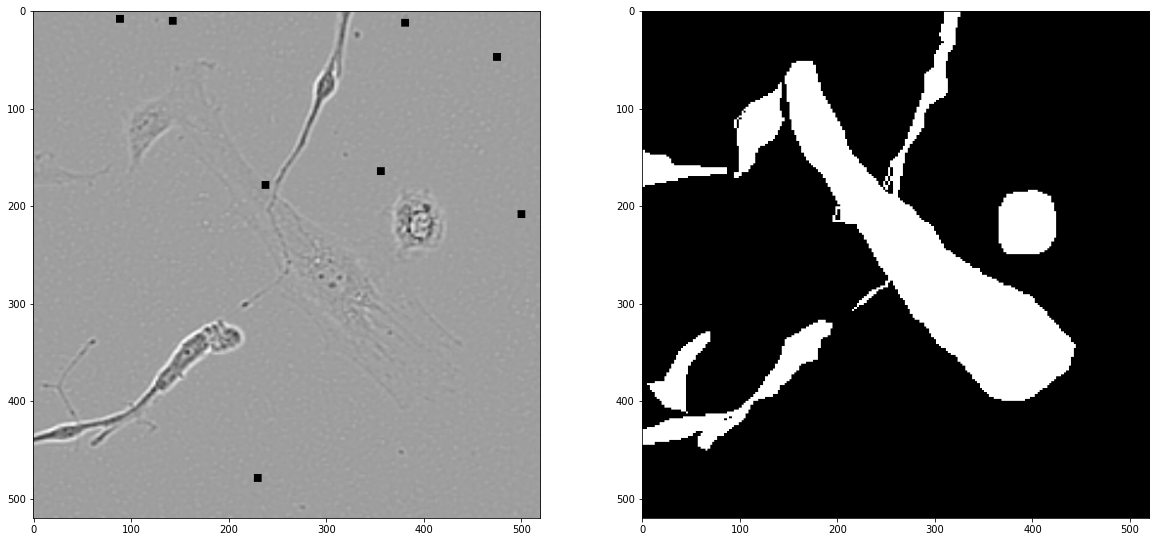

In [10]:
plt.figure(figsize=(20,22))
plt.subplot(1,2,1)
plt.imshow(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_0.tif"))
print(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_0.tif").shape)


plt.subplot(1,2,2)
plt.imshow(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_0_masks.tif"))
print(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_0_masks.tif").shape)


(520, 520, 3)
(520, 520, 3)


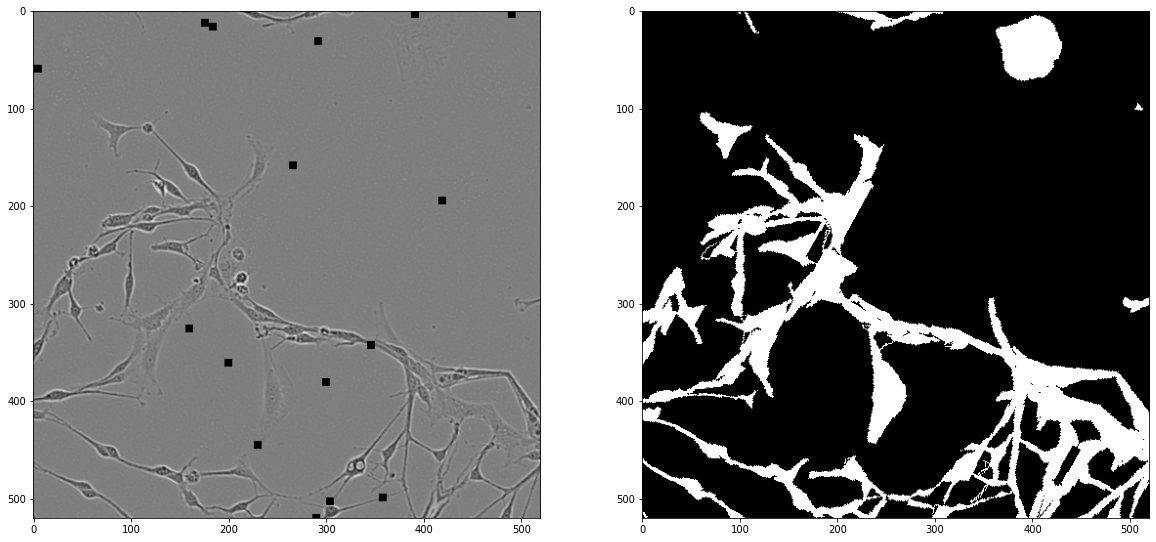

In [11]:
plt.figure(figsize=(20,22))
plt.subplot(1,2,1)
plt.imshow(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_1.tif"))
print(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_1.tif").shape)

plt.subplot(1,2,2)
plt.imshow(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_1_masks.tif"))
print(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_1_masks.tif").shape)


(520, 520, 3)
(520, 520, 3)


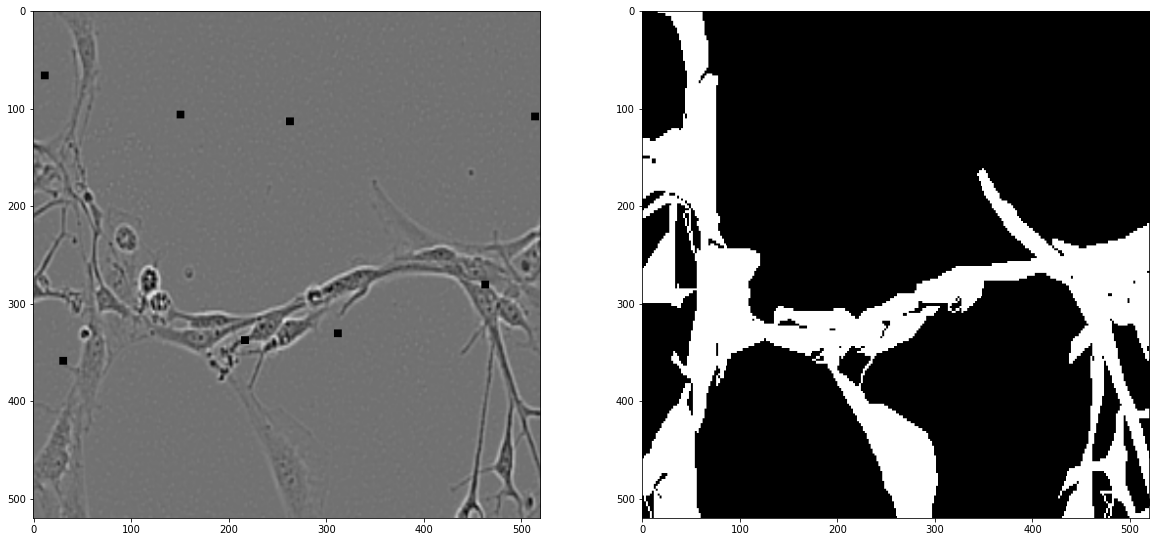

In [12]:
plt.figure(figsize=(20,22))
plt.subplot(1,2,1)
plt.imshow(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_2.tif"))
print(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_2.tif").shape)

plt.subplot(1,2,2)
plt.imshow(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_2_masks.tif"))
print(plt.imread("./cellpose/aug_train/img/ffc2ead3e8cc_2_masks.tif").shape)
